In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from numpy import array,linspace,tile,empty_like
import math

/home/ahuertas/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Common parameters and data

In [2]:
#plt.rcParams.update({'font.family': 'monospace'})
sns.set(style="whitegrid")
sns.set_style({'font.family':'serif', 'font.serif':['Times new roman']})

In [3]:
p_min_value = 0.1
p_max_value = 0.4
ratio_pin_pout = 0.1/0.4
tau_delay = 0.2

T_INSTANTS = 500

N_EQUATIONS = 5
N_EQUATIONS_QUORUM = 7

N_COLS_RESULT = T_INSTANTS*N_EQUATIONS
N_COLS_RESULT_QUORUM = T_INSTANTS*N_EQUATIONS_QUORUM


t = np.linspace(0,16,num=T_INSTANTS).round(2)

In [86]:
tau_delay

0.2

#### Input signal generation

In [99]:
'''
It creates the clock signal used during the experiments. It will contain a repetition of a zero value followed
by as many ones as indicated by "period". The amplitude determines the "value" of the signal for each position 
generated with a one. Example:
amplitude: 3
period: 2

signal: 0 3 3 0 3 3 0 3 3 ...

The signal has a position for each temporal mark indicated by T_INSTANTS
'''
def generate_clock_signal(amplitude, period):
    signal_result = []
    amplitude_result = []
    period_result = []
    
    previous_value = 1
    counter_period = 1
    
    for instant in range(0,T_INSTANTS):
        current_value_signal = 0
        if instant%(period+1) == 0:
            signal_result.append(0)
        else:
            signal_result.append(1)
            current_value_signal = 1
        
        # Stablish the value for the period
        if current_value_signal == previous_value:
            counter_period += 1
            period_result.append(counter_period)
        else:
            previous_value = current_value_signal
            counter_period = 1
            period_result.append(counter_period)            
        
        amplitude_result.append(amplitude)
        
    return [signal_result, amplitude_result, period_result]

clock_signal1, amplitude_signal1, period_signal1 = generate_clock_signal(amplitude=1, period=1)

In [100]:
print("Clock shape: %s ..." %(str(clock_signal1[:30])))
print("Amplitude shape: %s ..." %(str(amplitude_signal1[:30])))
print("Period shape: %s ..." %(str(period_signal1[:30])))

Clock shape: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1] ...
Amplitude shape: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...
Period shape: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...


#### Generation of pin and pout arrays

In [7]:
# Defines the calculation of the pin value for a particular instant of the input clock signal (n_pulse)
def pin_function(n_pulse, amplitude_signal, clock_signal):
    def p1_function(t, n_pulse):
        amplitude_value = amplitude_signal[n_pulse]*clock_signal[n_pulse]
        
        if clock_signal[n_pulse] == 1:
            return 1-math.e**(-tau_delay*amplitude_value*t[n_pulse])
        else:
            return math.e**(-tau_delay*amplitude_value*t[n_pulse])
    
    convolved = np.convolve(p1_function(t, n_pulse), clock_signal[n_pulse]*amplitude_signal[n_pulse], 'same')
    return np.interp([convolved], (0, 1), (p_min_value, p_max_value))[0]

def pout_function(pin_value):
    return pin_value/ratio_pin_pout

In [8]:
'''
It generates the pin and pout arrays, based on both clock and amplitude arrays. For that, it applies the
pin_function and pout_function over each position of both clock and amplitude arrays, and append the values of 
pin and pout in the corresponding arrays.

Returns: pin array, pout array
'''

def generate_pin_pout_arrays(clock_signal, amplitude_signal):
    pin = []
    pout = []
    # n_pulse: each pulse emitted by the clock function (each position of the array)
    # -> each instant evaluated
    for n_pulse in range(0, len(clock_signal)):
        pin_value = pin_function(n_pulse, amplitude_signal, clock_signal)[0]
        pin.append(pin_value)
        pout.append(pout_function(pin_value))
    
    return np.asarray(pin, dtype=np.float32), np.asarray(pout, dtype=np.float32)

In [9]:
pin1, pout1 = generate_pin_pout_arrays(clock_signal1, amplitude_signal1)

#### Equations

In [10]:
# Equation that models the production of molecules from the TN perspective, which creates biofilm
def eqn_TN(y,t,pin,pout):
    k_A = 2e-8
    k_R = 2e-8
    K_A = 1e-9
    K_R = 1e-9
    k_0 = 1e-2
    k_1 = 0.01
    k_2 = 0.1
    k_3 = 1e-2
    k_4 = 0.1
    k_5 = 0.1
    c_A = 2.7e-2
    c_R = 2.7e-2
    D=4.9e-6
    
    A = y[0]
    R = y[1]
    RA = y[2]
    C = y[3]
    Ae = y[4]
    
    dA = c_A+((k_A*C)/(K_A+C))-k_0*A-k_1*R*A+k_2*RA-pout*A+pin*Ae
    dR = c_R+((k_R*C)/(K_R+C))-k_3*R-k_1*R*A+k_2*RA
    dRA = k_1*R*A-k_2*RA-2*k_4*(RA**2)+2*k_5
    dC = k_4*(RA**2)-k_5*C
    dAe =(pout*A-pin*Ae)-D*Ae
    
    return [dA,dR,dRA,dC,dAe]

In [11]:
# Equation that models the production of molecules from the JN perspective, which performs the attack to disrupt 
# the formation of biofilm
def eqn_JN(y,t, pin, pout):
    
    # Replicates the solution array based on T_INSTANTS (positions of the input signal)
    k_A = 2e-8
    k_R = 2e-8
    K_A = 1e-9
    K_R = 1e-9
    k_0 = 1e-2
    k_1 = 0.01
    k_2 = 0.1
    k_3 = 1e-2
    k_4 = 0.1
    k_5 = 0.1
    c_A = 2.7e-2
    c_R = 2.7e-2
    D=4.9e-6
    
    A = y[0]
    R = y[1]
    RA = y[2]
    C = y[3]
    Ae = y[4]
    
    # Inicialise the result as an array of N_COLS_RESULT positions: space reservation for writting
    dy = np.zeros((N_COLS_RESULT,))
    
    # dA
    dy[0::N_EQUATIONS] = c_A+((k_A*C)/(K_A+C))-k_0*A-k_1*R*A+k_2*RA-pout*A+pin*Ae
    
    # dR
    dy[1::N_EQUATIONS] = c_R+((k_R*C)/(K_R+C))-k_3*R-k_1*R*A+k_2*RA
    
    # dRA
    dy[2::N_EQUATIONS] = k_1*R*A-k_2*RA-2*k_4*(RA**2)+2*k_5
    
    # dC
    dy[3::N_EQUATIONS] = k_4*(RA**2)-k_5*C
    
    # dAe
    dy[4::N_EQUATIONS] = (pout*A-pin*Ae)-D*Ae
    
    return dy

In [12]:
# Equation that models the production of molecules from the JN perspective, which performs the attack to disrupt 
# the formation of biofilm
# Implementation of the equations including the mitigation technique "quorum quenching"
def eqn_JN_quorum(y,t, pin, pout, kAA_=2e-8, kRR_=2e-8, lA_=1e-2, lR_=1e-2):

    # Replicates the solution array based on T_INSTANTS (positions of the input signal)
    k_A = 2e-8
    k_R = 2e-8
    K_A = 1e-9
    K_R = 1e-9
    k_0 = 1e-2
    k_1 = 0.01
    k_2 = 0.1
    k_3 = 1e-2
    k_4 = 0.1
    k_5 = 0.1
    c_A = 2.7e-2
    c_R = 2.7e-2
    D=4.9e-6
    
    # Variables used for modelling the production of molecular degradation signals
    #kAA_ = 2e-8
    #kRR_ = 2e-8
    #lA_ = 1e-2 # Same values as k_0
    #lR_ = 1e-2
    
    A = y[0]
    R = y[1]
    RA = y[2]
    C = y[3]
    Ae = y[4]
    
    A_ = y[5]
    R_ = y[6]
    
    # Inicialize the result as an array of N_COLS_RESULT_QUORUM positions: space reservation for writting
    dy = np.zeros((N_COLS_RESULT_QUORUM,))
    
    # dA
    dy[0::N_EQUATIONS_QUORUM] = c_A+((k_A*C)/(K_A+C))-k_0*A-k_1*R*A+k_2*RA-pout*A+pin*Ae - kAA_*A*A_
    
    # dR
    dy[1::N_EQUATIONS_QUORUM] = c_R+((k_R*C)/(K_R+C))-k_3*R-k_1*R*A+k_2*RA - kRR_*R*R_
    
    # dRA
    dy[2::N_EQUATIONS_QUORUM] = k_1*R*A-k_2*RA-2*k_4*(RA**2)+2*k_5
    
    # dC
    dy[3::N_EQUATIONS_QUORUM] = k_4*(RA**2)-k_5*C
    
    # dAe
    dy[4::N_EQUATIONS_QUORUM] = (pout*A-pin*Ae)-D*Ae
    
    # dA_
    dy[5::N_EQUATIONS_QUORUM] = -lA_*A_ - kAA_*A*A_
    
    # dR_
    dy[6::N_EQUATIONS_QUORUM] = -lR_*R_ - kRR_*R*R_
    
    return dy

In [13]:
# Method that formats the output from the JN results, where the data grouped by different N_EQUATIONS is 
# transformed
def format_output(data):
    start_position_input = 0
    position_counter = 0

    result = []
    
    for t_instant_data in data:
        #print("start_position_input: ", start_position_input)
        #print("position_counter: ", position_counter)
        
        partial_result = []
        for input_position in range(0, T_INSTANTS):
            partial_result.append(t_instant_data[start_position_input:start_position_input+N_EQUATIONS])

        result.append(partial_result[position_counter])

        start_position_input += N_EQUATIONS
        position_counter += 1
        
    return np.array(result)

In [14]:
# Base situation (amplitude 1)

# TN initialization values
y0 = [2,0.15,0,0,0.1]

# JN initialization values
y1 = [0.2,0.15,0,0,0.01]
y2 = [1,0.15,0,0,0.01]

# JN initialization values with quorum quenching mitigation
y1_quorum = [0.2,0.15,0,0,0.1,0.1,0.075] # A_ and R_ are initialized as half of the values of A and R, respectively
y2_quorum = [1,0.15,0,0,0.1,0.5,0.075]

clock_signal_base, amplitude_signal_base, period_signal_base = generate_clock_signal(amplitude=1, period=1)
pin_base, pout_base = generate_pin_pout_arrays(clock_signal_base, amplitude_signal_base)

y1_init = tile(array(y1),T_INSTANTS)
y2_init = tile(array(y2),T_INSTANTS)

y1_init_quorum = tile(array(y1_quorum),T_INSTANTS)
y2_init_quorum = tile(array(y2_quorum),T_INSTANTS)

# TN simulation
tn = odeint(eqn_TN,y0,t,args=(0.1,0.1,))

# JN simulation without mitigation

# jn: low power
jn = odeint(eqn_JN,y1_init,t, args=(pin_base, pout_base))
jn = format_output(jn)

# jn1: high power
jn1 = odeint(eqn_JN,y2_init,t, args=(pin_base, pout_base))
jn1 = format_output(jn1)

# JN simulation with quorum quenching mitigation
jn_quorum = odeint(eqn_JN_quorum,y1_init_quorum,t, args=(pin_base, pout_base))
jn_quorum = format_output(jn_quorum)

jn1_quorum = odeint(eqn_JN_quorum,y2_init_quorum,t, args=(pin_base, pout_base))
jn1_quorum = format_output(jn1_quorum)

#### Transmission of legitimate signal without delay

In [15]:
# value used to indicate how the TN and DN grow (PROPORTION_DN multiplied by the number of TN bacteria)
PROPORTION_DN = 10

r=0.0005 #5um
# Daniel's distance values
#r1=0.5 #5000um
#r2=0.05 #500um

r1=1 #10000um
r2=0.05 #500um
v=np.sqrt(2)/2

hj=1/(1+np.exp((r1-v*t)/np.sqrt(2)))
hj1=1/(1+np.exp((r2-v*t)/np.sqrt(2)))
ht_list = []
s_list = []
ps_list = []
pt_list = []
pt_quorum_list = []
pt_amplification_list = []
pl_list = []
pldb_list = []
n_t = []

#pt = 0
#pt_quorum = 0
#pt_amplification = 0

#print(hj,hj1)
for ii in range(0,T_INSTANTS):
    n_t.append(ii+1)
    
    ht=1/(1+np.exp((r-v*t[ii])/np.sqrt(2))) # equation (7)
    ht_list.append(ht)

    s=n_t[ii]*np.convolve(ht_list[ii],tn[:,4],'same') # equation (8). Convolve ht (communication channel TN-NR) with Ae values
    s_list.append(s)
 
    pt = n_t[ii] * (np.sum(np.linalg.norm(tn[:,4])**2)/(len(tn[:,4])))
    #pt_list.append(pt*10**-5) #UPDATED: changed the original value ("pt")
    pt_list.append(pt)
    
    pt_quorum = n_t[ii] * (np.sum(np.linalg.norm(tn[:,4])**2)/(len(tn[:,4])))
    pt_quorum_list.append(pt_quorum)
    
    pt_amplification = PROPORTION_DN * n_t[ii] * (np.sum(np.linalg.norm(tn[:,4])**2)/(len(tn[:,4])))
    pt_amplification_list.append(pt_amplification)
    
    ps=(np.sum(np.linalg.norm(s))**2)/len(s)
    ps_list.append(ps)

    pl = pt_list[ii]/ps_list[ii] # Path Loss
    pl_list.append(pl)
    pldb = 10*np.log10(pl_list[ii]) # Path Loss in dB
    pldb_list.append(pldb)

pp = np.polyfit(t,s,5)

pps = 9.36476194e-4*(t**5)-5.26310604e-2*(t**4)+1.26170102*(t**3)-1.81137118e1*(t**2)+1.86933908e2*t+1.01037055e2

#print(pp)

In [16]:
#for p in range(0,5):
#    print(p * 500 * (np.sum(np.linalg.norm(tn[:,4])**2)/(len(tn[:,4]))))


#### Transmission of interference signal without delay

In [17]:
'''
LEGEND:

- pljdb: path loss of JN in dB. Low power and distance r1
- plj1db: path loss of JN in dB. High power and distance r1

- pljdbr: path loss of JN in dB. Low power and distance r2
- plj1dbr: path loss of JN in dB. High power and distance r2

- pj/pj1: power of the jamming signal
- sj: end-to-end communication system (channel)

- pr/pr1 = power on the receiver
- snr/snr1 = SNR of the communication system
'''

def transmission_interference_signal_without_delay(jn, jn1):
    n_j=[]
    pj_list=[]
    pj1_list=[]
    ptj_list=[]
    ptj1_list=[]
    sj_list = []
    sj1_list = []
    sjr_list = []
    sj1r_list = []
    psj_list = []
    psjr_list = []
    psj1_list = []
    psj1r_list = []
    plj_list = []
    plj1_list = []
    pljdb_list = []
    plj1db_list = []
    pljr_list = []
    plj1r_list = []
    pljdbr_list = []
    plj1dbr_list = []
    
    pr_list = []
    pr1_list = []
    prr_list = []
    pr1r_list = []
    snrdb_list = []
    snr1db_list = []
    snrdbr_list = []
    snr1dbr_list = []
    p_noise_list = []
    
    noise = np.random.normal(0,1,T_INSTANTS)

    for ii in range(0,T_INSTANTS):
        
        n_j.append(ii+1)
        
        pj = n_j[ii] * (np.sum(np.linalg.norm(jn[:,4])**2)/(len(jn[:,4])))
        pj1 = n_j[ii] * (np.sum(np.linalg.norm(jn1[:,4])**2)/(len(jn1[:,4])))
        pj_list.append(pj)
        pj1_list.append(pj1)
        
        # Calculation of P_noise
        p_noise = n_j[ii] * (np.sum(np.linalg.norm(noise)**2)/(len(noise)))
        p_noise_list.append(p_noise)
        
        # Distance 1

        sj = s+(n_j[ii]*np.convolve(hj,jn[:,4],'same'))+noise[ii] # Legitimate + interference signal for low power
        sj1 = s+(n_j[ii]*np.convolve(hj,jn1[:,4],'same'))+noise[ii] # Legitimate + interference signal for high power
        sj_list.append(sj)
        sj1_list.append(sj1)
        
        psj=(np.sum(np.linalg.norm(sj)**2)/len(sj_list[ii])) # Received signal for low power
        psj1=(np.sum(np.linalg.norm(sj1)**2)/len(sj1_list[ii])) # Received signal for high power
        psj_list.append(psj)
        psj1_list.append(psj1)
        
        ptj = pt_list[ii]
        ptj_list.append(ptj)
        ptj1 = pt_list[ii]
        ptj1_list.append(ptj1)

        plj = ptj_list[ii]/psj_list[ii] # Path Loss Low Power
        plj1 = ptj1_list[ii]/psj1_list[ii] # Path Loss High Power       
        plj_list.append(plj)
        plj1_list.append(plj1)

        pljdb = 10*np.log10(plj_list[ii]) # Path Loss in dB Low Power
        plj1db = 10*np.log10(plj1_list[ii]) # Path Loss in dB High Power
        pljdb_list.append(pljdb)
        plj1db_list.append(plj1db)
        
        # Calculation of PR (power on the receiver)
        # P_{R,no} = P_{TN,no} - P_{LJ,no}
        pr = pt_list[ii] - plj_list[ii]
        pr1 = pt_list[ii] - plj1_list[ii]
        pr_list.append(pr)
        pr1_list.append(pr1)
        
        # Calculation of the SNR
        # SNR_i = P_{TN,i} / (P_{JN,i} + P_noise)
        snr = pt_list[ii]/(pj_list[ii]+0.3)#p_noise_list[ii])
        snr1 = pt_list[ii]/(pj1_list[ii]+0.3)#p_noise_list[ii])
        snrdb_list.append(10*np.log10(snr))
        snr1db_list.append(10*np.log10(snr1))

        # Distance 2

        sjr = s+(n_j[ii]*np.convolve(hj1,jn[:,4],'same'))+noise[ii] # Legitimate + interference signal for low power
        sj1r = s+(n_j[ii]*np.convolve(hj1,jn1[:,4],'same'))+noise[ii] # Legitimate + interference signal for high power
        sjr_list.append(sjr)
        sj1r_list.append(sj1r)
        
        psjr=(np.sum(np.linalg.norm(sjr_list[ii])**2)/len(sjr_list[ii])) # Received signal for low power
        psj1r=(np.sum(np.linalg.norm(sj1r_list[ii])**2)/len(sj1r_list[ii])) # Received signal for high power
        psjr_list.append(psjr)
        psj1r_list.append(psj1r)

        pljr = ptj_list[ii]/psjr_list[ii] # Path Loss Low Power
        plj1r = ptj1_list[ii]/psj1r_list[ii] # Path Loss High Power
        pljr_list.append(pljr)
        plj1r_list.append(plj1r)

        pljdbr = 10*np.log10(pljr_list[ii]) # Path Loss in dB Low Power
        plj1dbr = 10*np.log10(plj1r_list[ii]) # Path Loss in dB High Power
        pljdbr_list.append(pljdbr)
        plj1dbr_list.append(plj1dbr)
        
        # Calculation of PR (power on the receiver)
        # P_{R,no} = P_{TN,no} - P_{LJ,no}
        prr = pt_list[ii] - pljr_list[ii]
        pr1r = pt_list[ii] - plj1r_list[ii]
        prr_list.append(prr)
        pr1r_list.append(pr1r)
        
        # Calculation of the SNR
        # SNR_i = P_{TN,i} / (P_{JN,i} + P_noise)
        snrr = pt_list[ii]/(pj_list[ii]+0.3)#p_noise_list[ii])
        snr1r = pt_list[ii]/(pj1_list[ii]+0.3)#p_noise_list[ii])
        snrdbr_list.append(10*np.log10(snrr))
        snr1dbr_list.append(10*np.log10(snr1r))
        
    return n_j, pldb*np.array([1,]*T_INSTANTS), pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list

#### Transmission of interference signal without delay (QUORUM QUENCHING)

In [18]:
'''
LEGEND:

- pljdb: path loss of JN in dB. Low power and distance r1
- plj1db: path loss of JN in dB. High power and distance r1

- pljdbr: path loss of JN in dB. Low power and distance r2
- plj1dbr: path loss of JN in dB. High power and distance r2

- pj/pj1: power of the jamming signal
- sj: end-to-end communication system (channel)

- pr/pr1 = power on the receiver
- snr/snr1 = SNR of the communication system
'''

def transmission_interference_signal_without_delay_quorum(jn_quorum, jn1_quorum):
    n_j=[]
    
    pj_list=[]
    pj1_list=[]
    
    ptj_list=[]
    ptj1_list=[]

    sj_list = []
    sj1_list = []
    
    sjr_list = []
    sj1r_list = []
    
    psj_list = []
    psjr_list = []
    
    psj1_list = []
    psj1r_list = []
    
    plj_list = []
    plj1_list = []
    
    pljdb_list = []
    plj1db_list = []
    
    pljr_list = []
    plj1r_list = []
    
    pljdbr_list = []
    plj1dbr_list = []
    
    pr_list = []
    pr1_list = []
    prr_list = []
    pr1r_list = []
    snrdb_list = []
    snr1db_list = []
    snrdbr_list = []
    snr1dbr_list = []
    p_noise_list = []
    
    noise = np.random.normal(0,1,T_INSTANTS)

    for ii in range(0,T_INSTANTS):       
        n_j.append(ii+1)
        
        pj = n_j[ii] * (np.sum(np.linalg.norm(jn_quorum[:,4]**2))/(len(jn_quorum[:,4])))
        pj1 = n_j[ii] * (np.sum(np.linalg.norm(jn1_quorum[:,4]**2))/(len(jn1_quorum[:,4])))
        pj_list.append(pj)
        pj1_list.append(pj1)
        
        # Calculation of P_noise
        p_noise = n_j[ii] * (np.sum(np.linalg.norm(noise)**2)/(len(noise)))
        p_noise_list.append(p_noise)
        
        # Distance 1

        sj = s+(n_j[ii]*np.convolve(hj,jn_quorum[:,4],'same'))+noise[ii] # Legitimate + interference signal for low power
        sj1 = s+(n_j[ii]*np.convolve(hj,jn1_quorum[:,4],'same'))+noise[ii] # Legitimate + interference signal for high power
        sj_list.append(sj)
        sj1_list.append(sj1)
        
        psj=(np.sum(np.linalg.norm(sj_list[ii])**2)/len(sj_list[ii])) # Received signal for low power
        psj1=(np.sum(np.linalg.norm(sj1_list[ii])**2)/len(sj1_list[ii])) # Received signal for high power
        psj_list.append(psj)
        psj1_list.append(psj1)

        ptj = pt_list[ii]
        ptj_list.append(ptj)
        ptj1 = pt_list[ii]
        ptj1_list.append(ptj1)

        plj = ptj_list[ii]/psj_list[ii] # Path Loss Low Power
        plj1 = ptj1_list[ii]/psj1_list[ii] # Path Loss High Power
        plj_list.append(plj)
        plj1_list.append(plj1)

        pljdb = 10*np.log10(plj_list[ii]) # Path Loss in dB Low Power
        plj1db = 10*np.log10(plj1_list[ii]) # Path Loss in dB High Power
        pljdb_list.append(pljdb)
        plj1db_list.append(plj1db)

        # Calculation of PR (power on the receiver)
        # P_{R,no} = P_{TN,no} - P_{LJ,no}
        pr = pt_list[ii] - plj_list[ii]
        pr1 = pt_list[ii] - plj1_list[ii]
        pr_list.append(pr)
        pr1_list.append(pr1)
        
        # Calculation of the SNR
        # SNR_i = P_{TN,i} / (P_{JN,i} + P_noise)
        snr = pt_list[ii]/(pj_list[ii]+0.3)#p_noise_list[ii])
        snr1 = pt_list[ii]/(pj1_list[ii]+0.3)#p_noise_list[ii])
        snrdb_list.append(10*np.log10(snr))
        snr1db_list.append(10*np.log10(snr1))
        
        # Distance 2

        sjr = s+(n_j[ii]*np.convolve(hj1,jn_quorum[:,4],'same'))+noise[ii] # Legitimate + interference signal for low power
        sj1r = s+(n_j[ii]*np.convolve(hj1,jn1_quorum[:,4],'same'))+noise[ii] # Legitimate + interference signal for high power
        sjr_list.append(sjr)
        sj1r_list.append(sj1r)
        
        psjr=(np.sum(np.linalg.norm(sjr_list[ii])**2)/len(sjr_list[ii])) # Received signal for low power
        psj1r=(np.sum(np.linalg.norm(sj1r_list[ii])**2)/len(sj1r_list[ii])) # Received signal for high power
        psjr_list.append(psjr)
        psj1r_list.append(psj1r)

        pljr = ptj_list[ii]/psjr_list[ii] # Path Loss Low Power
        plj1r = ptj1_list[ii]/psj1r_list[ii] # Path Loss High Power
        pljr_list.append(pljr)
        plj1r_list.append(plj1r)

        pljdbr = 10*np.log10(pljr_list[ii]) # FsPath Loss in dB Low Power
        plj1dbr = 10*np.log10(plj1r_list[ii]) # Path Loss in dB High Power
        pljdbr_list.append(pljdbr)
        plj1dbr_list.append(plj1dbr)

        # Calculation of PR (power on the receiver)
        # P_{R,no} = P_{TN,no} - P_{LJ,no}
        prr = pt_list[ii] - pljr_list[ii]
        pr1r = pt_list[ii] - plj1r_list[ii]
        prr_list.append(prr)
        pr1r_list.append(pr1r)
        
        # Calculation of the SNR
        # SNR_i = P_{TN,i} / (P_{JN,i} + P_noise)
        snrr = pt_list[ii]/(pj_list[ii]+0.3)#p_noise_list[ii])
        snr1r = pt_list[ii]/(pj1_list[ii]+0.3)#p_noise_list[ii])
        snrdbr_list.append(10*np.log10(snrr))
        snr1dbr_list.append(10*np.log10(snr1r))
    
    return n_j, pldb*np.array([1,]*T_INSTANTS), pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list

#### Transmission of interference signal without delay (AMPLIFICATION)

In [19]:
def transmission_interference_signal_without_delay_amplification(jn, jn1):
    n_j=[]
    n_d=[]
    
    pj_list=[]
    pj1_list=[]
    ptj_list=[]
    ptj1_list=[]
    sj_list = []
    sj1_list = []
    sjr_list = []
    sj1r_list = []
    psj_list = []
    psjr_list = []
    psj1_list = []
    psj1r_list = []
    plj_list = []
    plj1_list = []
    pljdb_list = []
    plj1db_list = []
    pljr_list = []
    plj1r_list = []
    pljdbr_list = []
    plj1dbr_list = []
    
    pr_list = []
    pr1_list = []
    prr_list = []
    pr1r_list = []
    snrdb_list = []
    snr1db_list = []
    snrdbr_list = []
    snr1dbr_list = []
    p_noise_list = []
    
    noise = np.random.normal(0,1,T_INSTANTS)

    for ii in range(0,T_INSTANTS):
        
        n_j.append(ii+1)
        
        pj = n_j[ii] * (np.sum(np.linalg.norm(jn[:,4]**2))/(len(jn[:,4])))
        pj1 = n_j[ii] * (np.sum(np.linalg.norm(jn1[:,4]**2))/(len(jn1[:,4])))
        pj_list.append(pj)
        pj1_list.append(pj1)
        
        # Calculation of P_noise
        p_noise = n_j[ii] * (np.sum(np.linalg.norm(noise)**2)/(len(noise)))
        p_noise_list.append(p_noise)
        
        # Distance 1
        
        sj = s*(1+PROPORTION_DN)+(n_j[ii]*np.convolve(hj,jn[:,4],'same'))+noise[ii]
        sj1 = s *(1+PROPORTION_DN)+(n_j[ii]*np.convolve(hj,jn1[:,4],'same'))+noise[ii]
        sj_list.append(sj)
        sj1_list.append(sj1)

        psj=(np.sum(np.linalg.norm(sj_list[ii])**2)/len(sj_list[ii])) # Received signal for low power
        psj1=(np.sum(np.linalg.norm(sj1_list[ii])**2)/len(sj1_list[ii])) # Received signal for high power
        psj_list.append(psj)
        psj1_list.append(psj1)

        ptj = pt_amplification_list[ii]
        ptj_list.append(ptj)
        ptj1 = pt_amplification_list[ii]
        ptj1_list.append(ptj1)

        plj = ptj_list[ii]/psj_list[ii] # Path Loss Low Power
        plj1 = ptj1_list[ii]/psj1_list[ii] # Path Loss High Power
        plj_list.append(plj)
        plj1_list.append(plj1)

        pljdb = 10*np.log10(plj_list[ii]) # Path Loss in dB Low Power
        plj1db = 10*np.log10(plj1_list[ii]) # Path Loss in dB High Power
        pljdb_list.append(pljdb)
        plj1db_list.append(plj1db)
        
        # Calculation of PR (power on the receiver)
        # P_{R,no} = P_{TN,no} - P_{LJ,no}
        pr = pt_list[ii] - plj_list[ii]
        pr1 = pt_list[ii] - plj1_list[ii]
        pr_list.append(pr)
        pr1_list.append(pr1)
        
        # Calculation of the SNR
        # SNR_i = P_{TN,i} / (P_{JN,i} + P_noise)
        snr = pt_list[ii]/(pj_list[ii]+0.3)#p_noise_list[ii])
        snr1 = pt_list[ii]/(pj1_list[ii]+0.3)#p_noise_list[ii])
        snrdb_list.append(10*np.log10(snr))
        snr1db_list.append(10*np.log10(snr1))

        # Distance 2

        sjr = s * (1+PROPORTION_DN)+(n_j[ii]*np.convolve(hj1,jn[:,4],'same'))+noise[ii]
        sj1r = s * (1+PROPORTION_DN)+(n_j[ii]*np.convolve(hj1,jn1[:,4],'same'))+noise[ii]
        sjr_list.append(sjr)
        sj1r_list.append(sj1r)

        psjr=(np.sum(np.linalg.norm(sjr_list[ii])**2)/len(sjr_list[ii])) # Received signal for low power
        psj1r=(np.sum(np.linalg.norm(sj1r_list[ii])**2)/len(sj1r_list[ii])) # Received signal for high power
        psjr_list.append(psjr)
        psj1r_list.append(psj1r)

        pljr = ptj_list[ii]/psjr_list[ii] # Path Loss Low Power
        plj1r = ptj1_list[ii]/psj1r_list[ii] # Path Loss High Power
        pljr_list.append(pljr)
        plj1r_list.append(plj1r)

        pljdbr = 10*np.log10(pljr_list[ii]) # FsPath Loss in dB Low Power
        plj1dbr = 10*np.log10(plj1r_list[ii]) # Path Loss in dB High Power
        pljdbr_list.append(pljdbr)
        plj1dbr_list.append(plj1dbr)
        
        # Calculation of PR (power on the receiver)
        # P_{R,no} = P_{TN,no} - P_{LJ,no}
        prr = pt_list[ii] - pljr_list[ii]
        pr1r = pt_list[ii] - plj1r_list[ii]
        prr_list.append(prr)
        pr1r_list.append(pr1r)
        
        # Calculation of the SNR
        # SNR_i = P_{TN,i} / (P_{JN,i} + P_noise)
        snrr = pt_list[ii]/(pj_list[ii]+0.3)#p_noise_list[ii])
        snr1r = pt_list[ii]/(pj1_list[ii]+0.3)#p_noise_list[ii])
        snrdbr_list.append(10*np.log10(snrr))
        snr1dbr_list.append(10*np.log10(snr1r))
        
    return n_j, pldb*np.array([1,]*T_INSTANTS), pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list

#### Plots

#### Polynomial fitting

In [20]:
def plot_polynomial_fitting():
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    ax.plot(t,s, 'k', color='#0485d1',label="Received signal")
    ax.plot(t,pps, '--', color='#3f9b0b',label="Received signal")

    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (hours)',fontweight='bold',fontsize=16)
    ax.set_ylabel('Protein Concentration (nM)',fontweight='bold',fontsize=16)
    ax.tick_params(labelsize=16)
    leg = ax.legend(loc='best',fancybox=True, shadow=True, ncol=5, frameon='True',fontsize=16)
    leg.get_frame().set_edgecolor('black')

#### Legitimate signal attenuation in respect to time

In [21]:
def plot_legitimate_signal_attenuation():
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    ax.plot(t,pldb_list, 'k', color='#0485d1',label="Legitimate signal")

    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (hours)',fontweight='bold',fontsize=16)
    ax.set_ylabel('Channel Attenuation (dB)',fontweight='bold',fontsize=16)
    ax.tick_params(labelsize=16)
    leg = ax.legend(loc='best',fancybox=True, shadow=True, ncol=5, frameon='True',fontsize=16)
    leg.get_frame().set_edgecolor('black')

#### Jamming signal attenuation after 16 hours

In [22]:
# It prints the attenuation (in dB) for the comparison between 2 distances and high/low power signals

def plot_jamming_signal_attenuation_complete(n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, filename):
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
    
    #sns.set_style({'font.family':'serif', 'font.serif':['Arial']})
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    #ax.plot(n_j,pldb_list, 'k', color='#3f9b0b',label="Legitimate signal")
    ax.plot(t,pljdb_list, 'k', color='#0485d1',label="Jamming signal - low power, $r_1$", linewidth=2.0)
    ax.plot(t,plj1db_list, 'k', color='#fc5a50',label="Jamming signal - high power, $r_1$", linewidth=2.0)
    ax.plot(t,pljdbr_list, '--', color='#0485d1',label="Jamming signal - low power, $r_2$", linewidth=2.0)
    ax.plot(t,plj1dbr_list, '--', color='#fc5a50',label="Jamming signal - high power, $r_2$", linewidth=2.0)

    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (h)',fontweight='bold',fontsize=18)
    ax.set_ylabel('Channel Attenuation (dB)',fontweight='bold',fontsize=18)
    ax.tick_params(labelsize=16)
    
    # Put a legend below current axis
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=1, fontsize=18)
    
    plt.xticks([0,4,8,12,16])
    
    #leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=n_cols, frameon='True',fontsize=legend_size)
    #leg.get_frame().set_edgecolor('black')
    
    fig.savefig(filename, bbox_extra_artists=(legend,), bbox_inches='tight')
    #fig.savefig('image_output.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    #fig.savefig(filename)
    plt.show()

In [23]:
# It prints the attenuation (in dB) for the comparison between 2 distances and high/low power signals

def plot_jamming_signal_attenuation_complete_quorum(
        n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, 
        pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list, 
        filename):
    
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
    
    #sns.set_style({'font.family':'serif', 'font.serif':['Arial']})
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    #ax.plot(n_j,pldb_list, 'k', color='#3f9b0b',label="Legitimate signal")
    ax.plot(t,pljdb_list, 'k', color='#0485d1',label="Jamming signal - low power, $r_1$", linewidth=2.0)
    ax.plot(t,plj1db_list, 'k', color='#fc5a50',label="Jamming signal - high power, $r_1$", linewidth=2.0)
    ax.plot(t,pljdbr_list, '--', color='#0485d1',label="Jamming signal - low power, $r_2$", linewidth=2.0)
    ax.plot(t,plj1dbr_list, '--', color='#fc5a50',label="Jamming signal - high power, $r_2$", linewidth=2.0)
    
    ax.plot(t,pljdb_quorum_list, 'k', color='#800000',label="QQ Jamming signal - low power, $r_1$", linewidth=2.0)
    ax.plot(t,plj1db_quorum_list, 'k', color='#3f9b0b',label="QQ Jamming signal - high power, $r_1$", linewidth=2.0)
    ax.plot(t,pljdbr_quorum_list, '--', color='#800000',label="QQ Jamming signal - low power, $r_2$", linewidth=2.0)
    ax.plot(t,plj1dbr_quorum_list, '--', color='#3f9b0b',label="QQ Jamming signal - high power, $r_2$", linewidth=2.0)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (h)',fontweight='bold',fontsize=18)
    ax.set_ylabel('Channel Attenuation (dB)',fontweight='bold',fontsize=18)
    ax.tick_params(labelsize=16)
    
    # Put a legend below current axis
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=1, fontsize=18)
    
    plt.xticks([0,4,8,12,16])
    
    #leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=n_cols, frameon='True',fontsize=legend_size)
    #leg.get_frame().set_edgecolor('black')
    
    fig.savefig(filename, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

In [24]:
# It prints the attenuation (in dB) for the comparison between 2 distances and high/low power signals

def plot_jamming_signal_attenuation_complete_amplification(
        n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, 
        pldb_amplification_list, pljdb_amplification_list, plj1db_amplification_list, pljdbr_amplification_list, plj1dbr_amplification_list, 
        filename):
    
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
    
    #sns.set_style({'font.family':'serif', 'font.serif':['Arial']})
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    #ax.plot(n_j,pldb_list, 'k', color='#3f9b0b',label="Legitimate signal")
    ax.plot(t,pljdb_list, 'k', color='#0485d1',label="Jamming signal - low power, $r_1$", linewidth=2.0)
    ax.plot(t,plj1db_list, 'k', color='#fc5a50',label="Jamming signal - high power, $r_1$", linewidth=2.0)
    ax.plot(t,pljdbr_list, '--', color='#0485d1',label="Jamming signal - low power, $r_2$", linewidth=2.0)
    ax.plot(t,plj1dbr_list, '--', color='#fc5a50',label="Jamming signal - high power, $r_2$", linewidth=2.0)
    
    ax.plot(t,pljdb_amplification_list, 'k', color='#800000',label="AMPL Jamming signal - low power, $r_1$", linewidth=2.0)
    ax.plot(t,plj1db_amplification_list, 'k', color='#3f9b0b',label="AMPL Jamming signal - high power, $r_1$", linewidth=2.0)
    ax.plot(t,pljdbr_amplification_list, '--', color='#800000',label="AMPL Jamming signal - low power, $r_2$", linewidth=2.0)
    ax.plot(t,plj1dbr_amplification_list, '--', color='#3f9b0b',label="AMPL Jamming signal - high power, $r_2$", linewidth=2.0)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (h)',fontweight='bold',fontsize=18)
    ax.set_ylabel('Channel Attenuation (dB)',fontweight='bold',fontsize=18)
    ax.tick_params(labelsize=16)
    
    # Put a legend below current axis
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=1, fontsize=18)
    
    plt.xticks([0,4,8,12,16])
    
    #leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=n_cols, frameon='True',fontsize=legend_size)
    #leg.get_frame().set_edgecolor('black')
    
    fig.savefig(filename, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

In [25]:
def plot_jamming_signal_attenuation_specific(jn_list, labels, colors, filename, print_legitimate, legend_size=18, n_cols=2):
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
        
    fig, ax = plt.subplots(1, 1, figsize=(10,10))    
    
    # jn_list[X][0] has the array of time -> x-axis
    
    if print_legitimate == True:
        ax.plot(jn_list[0][0],jn_list[0][1], 'k', color='#f58231',label="Legitimate signal", linewidth=2.0)   # n_j , pldb_list
    
    for i in range(0, len(jn_list)):
        ax.plot(jn_list[i][0],jn_list[i][2], 'k', color=colors[i] ,label=labels[i], linewidth=2.0) # n_j, plj1dbr_list
        
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (h)',fontweight='bold',fontsize=18)
    ax.set_ylabel('Channel Attenuation (dB)',fontweight='bold',fontsize=18)
    ax.tick_params(labelsize=18)
    
    # Put a legend below current axis
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=n_cols, fontsize=legend_size)
    
    plt.xticks([0,4,8,12,16])
    
    #leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=n_cols, frameon='True',fontsize=legend_size)
    #leg.get_frame().set_edgecolor('black')
    
    fig.savefig(filename, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

In [26]:
def plot_jamming_signal_attenuation_specific_quorum(jn_list, jn_quorum_list, labels, colors, filename, print_legitimate, legend_size=18, n_cols=2):
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
        
    fig, ax = plt.subplots(1, 1, figsize=(10,10))    
    
    # jn_list[X][0] has the array of time -> x-axis
    
    if print_legitimate == True:
        ax.plot(jn_list[0][0],jn_list[0][1], 'k', color='#f58231',label="Legitimate signal", linewidth=2.0)   # n_j , pldb_list
    
    for i in range(0, len(jn_list)):
        ax.plot(jn_list[i][0],jn_list[i][2], 'k', color=colors[i] ,label=labels[i], linewidth=2.0) # n_j, plj1dbr_list
    
    for i in range(0, len(jn_quorum_list)):
        ax.plot(jn_quorum_list[i][0],jn_quorum_list[i][2], 'k', color=colors[i+len(jn_list)] ,label=labels[i+len(jn_list)], linewidth=2.0, linestyle='dashed') # n_j, plj1dbr_list
        
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (h)',fontweight='bold',fontsize=18)
    ax.set_ylabel('Channel Attenuation (dB)',fontweight='bold',fontsize=18)
    ax.tick_params(labelsize=18)
    
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=n_cols, fontsize=legend_size)

    plt.xticks([0,4,8,12,16])
    
    #leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=n_cols, frameon='True',fontsize=legend_size)
    #leg.get_frame().set_edgecolor('black')
    
    fig.savefig(filename, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

In [27]:
def plot_jamming_signal_attenuation_specific_amplification(jn_list, jn_amplification_list, labels, colors, filename, print_legitimate, legend_size=18, n_cols=2):
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
        
    fig, ax = plt.subplots(1, 1, figsize=(10,10))    
    
    # jn_list[X][0] has the array of time -> x-axis
    
    if print_legitimate == True:
        ax.plot(jn_list[0][0],jn_list[0][1], 'k', color='#f58231',label="Legitimate signal", linewidth=2.0)   # n_j , pldb_list
    
    for i in range(0, len(jn_list)):
        ax.plot(jn_list[i][0],jn_list[i][2], 'k', color=colors[i] ,label=labels[i], linewidth=2.0) # n_j, plj1dbr_list
    
    for i in range(0, len(jn_amplification_list)):
        ax.plot(jn_amplification_list[i][0],jn_amplification_list[i][2], 'k', color=colors[i+len(jn_list)] ,label=labels[i+len(jn_list)], linewidth=2.0, linestyle='dashed') # n_j, plj1dbr_list
        
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (h)',fontweight='bold',fontsize=18)
    ax.set_ylabel('Channel Attenuation (dB)',fontweight='bold',fontsize=18)
    ax.tick_params(labelsize=18)
    
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=n_cols, fontsize=legend_size)
    
    plt.xticks([0,4,8,12,16])
    
    #leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=n_cols, frameon='True',fontsize=legend_size)
    #leg.get_frame().set_edgecolor('black')
    
    fig.savefig(filename, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

### ATTACKS

#### Common

In [28]:
period = 1

In [29]:
import os 

if not os.path.exists("plots"):
    os.makedirs("plots")

#### Graph 2: Comparison between Low Power / High Power and distances

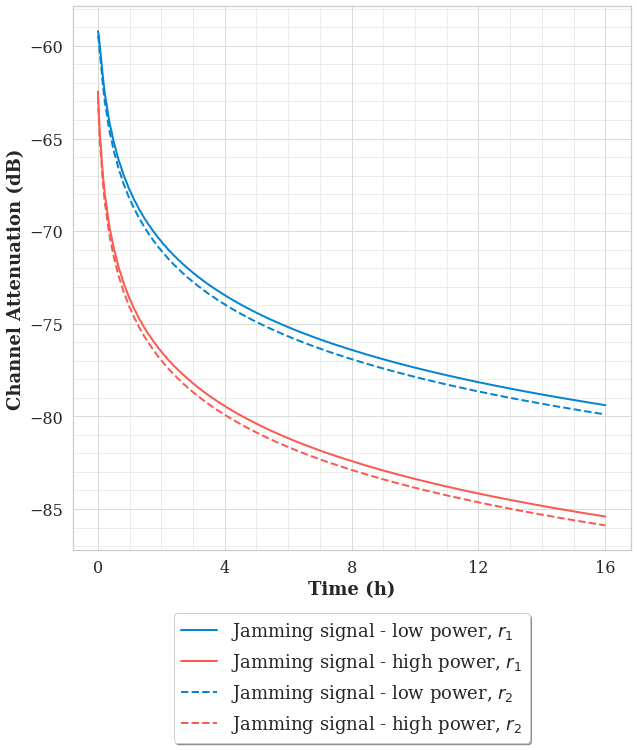

In [30]:
# JN without mitigation
n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn, jn1)

plot_jamming_signal_attenuation_complete(n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, "plots/expr2_power_distance.pdf")

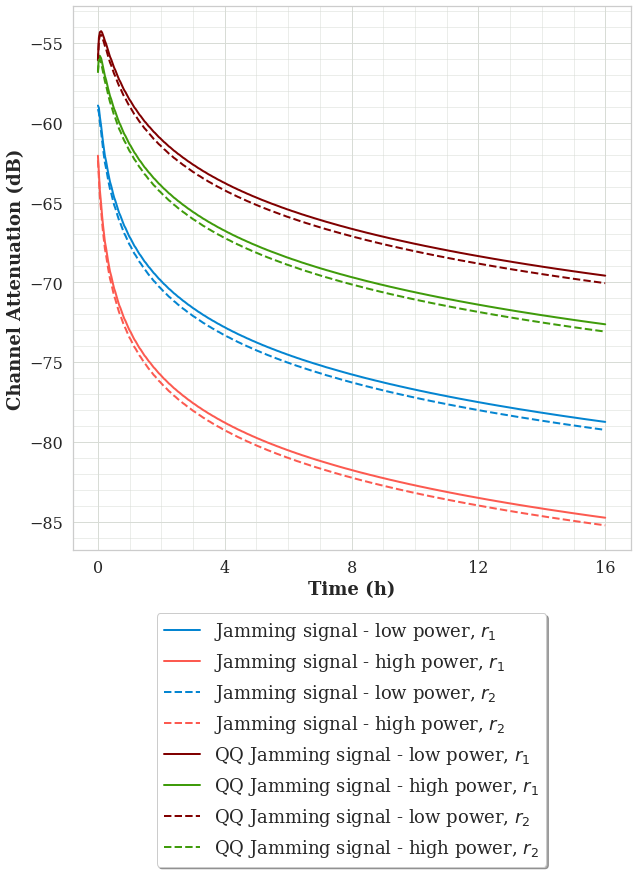

In [37]:
# JN with quorum sensing
n_j, pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list, pr_quorum_list, pr1_quorum_list, prr_quorum_list, pr1r_quorum_list, snrdb_quorum_list, snr1db_quorum_list, snrdbr_quorum_list, snr1dbr_quorum_list, pj_quorum_list, pj1_quorum_list = transmission_interference_signal_without_delay_quorum(jn_quorum, jn1_quorum)

plot_jamming_signal_attenuation_complete_quorum(
    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, 
    pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list,
    "plots/expr2_power_distance_quorum.pdf")

In [ ]:
################
# Zoom over a portion of the plot to better understand the behavior
################

In [84]:
# It prints the attenuation (in dB) for the comparison between 2 distances and high/low power signals

init_time = 0
end_time = 33

def plot_jamming_signal_attenuation_complete_quorum_zoom(
        n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, 
        pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list, 
        filename):
    
    #sns.set_style("whitegrid",{'font.sans-serif': u'Arial'})
    
    #sns.set_style({'font.family':'serif', 'font.serif':['Arial']})
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    #ax.plot(n_j,pldb_list, 'k', color='#3f9b0b',label="Legitimate signal")
    ax.plot(t[init_time:end_time],pljdb_list[init_time:end_time], 'k', color='#0485d1',label="Jamming signal - low power, $r_1$", linewidth=2.0)
    ax.plot(t[init_time:end_time],plj1db_list[init_time:end_time], 'k', color='#fc5a50',label="Jamming signal - high power, $r_1$", linewidth=2.0)
    ax.plot(t[init_time:end_time],pljdbr_list[init_time:end_time], '--', color='#0485d1',label="Jamming signal - low power, $r_2$", linewidth=2.0)
    ax.plot(t[init_time:end_time],plj1dbr_list[init_time:end_time], '--', color='#fc5a50',label="Jamming signal - high power, $r_2$", linewidth=2.0)
    
    ax.plot(t[init_time:end_time],pljdb_quorum_list[init_time:end_time], 'k', color='#800000',label="QQ Jamming signal - low power, $r_1$", linewidth=2.0)
    ax.plot(t[init_time:end_time],plj1db_quorum_list[init_time:end_time], 'k', color='#3f9b0b',label="QQ Jamming signal - high power, $r_1$", linewidth=2.0)
    ax.plot(t[init_time:end_time],pljdbr_quorum_list[init_time:end_time], '--', color='#800000',label="QQ Jamming signal - low power, $r_2$", linewidth=2.0)
    ax.plot(t[init_time:end_time],plj1dbr_quorum_list[init_time:end_time], '--', color='#3f9b0b',label="QQ Jamming signal - high power, $r_2$", linewidth=2.0)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
    ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

    ax.set_xlabel('Time (h)',fontweight='bold',fontsize=18)
    ax.set_ylabel('Channel Attenuation (dB)',fontweight='bold',fontsize=18)
    ax.tick_params(labelsize=16)
    
    # Put a legend below current axis
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=1, fontsize=18)
    
    #plt.xticks([0,4,8,12,16])
    
    #leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=n_cols, frameon='True',fontsize=legend_size)
    #leg.get_frame().set_edgecolor('black')
    
    fig.savefig(filename, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

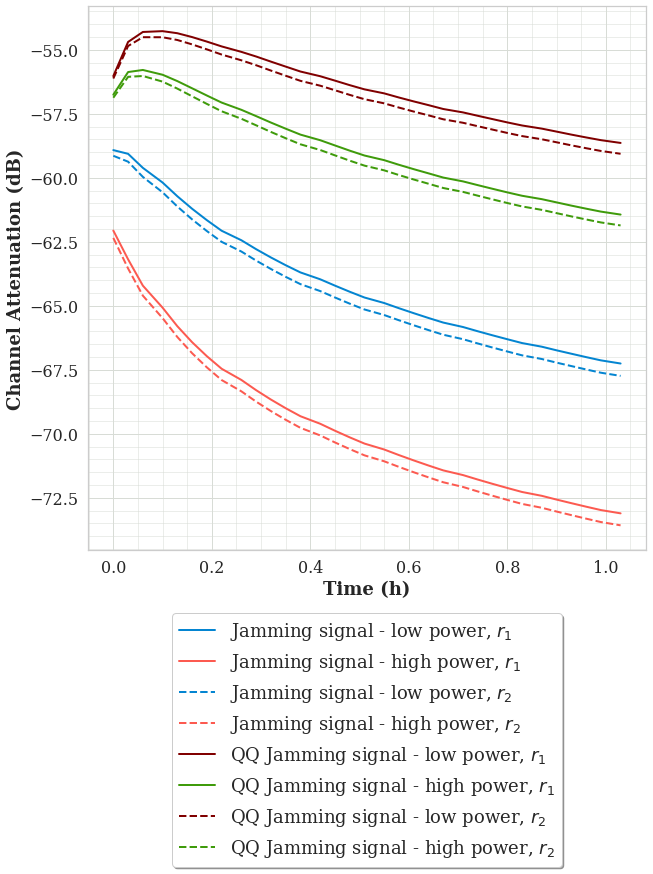

In [85]:
# JN with quorum sensing
n_j, pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list, pr_quorum_list, pr1_quorum_list, prr_quorum_list, pr1r_quorum_list, snrdb_quorum_list, snr1db_quorum_list, snrdbr_quorum_list, snr1dbr_quorum_list, pj_quorum_list, pj1_quorum_list = transmission_interference_signal_without_delay_quorum(jn_quorum, jn1_quorum)

plot_jamming_signal_attenuation_complete_quorum_zoom(
    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, 
    pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list,
    "plots/expr2_power_distance_quorum_zoom.pdf")

In [ ]:
############
############

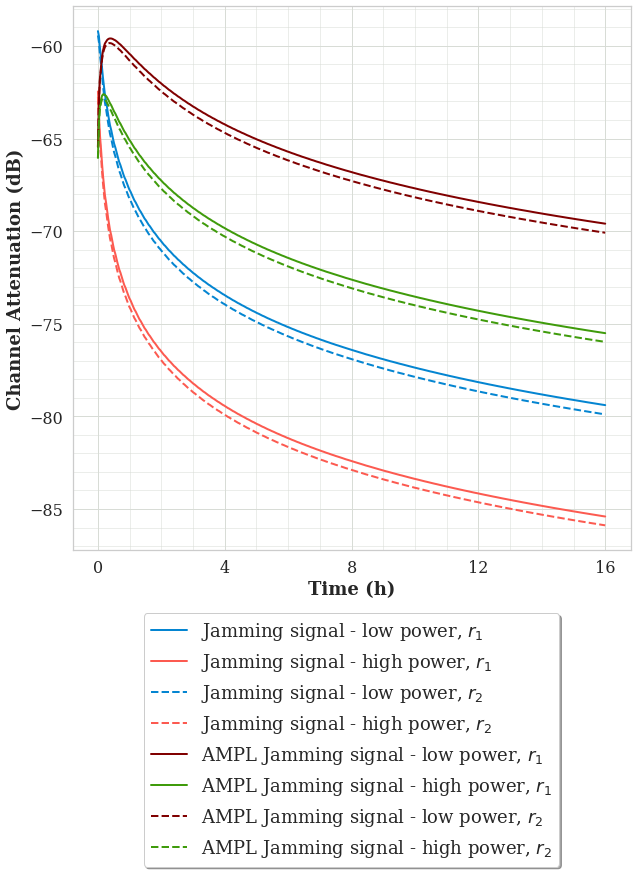

In [32]:
# JN with amplification
n_j, pldb_amplification_list, pljdb_amplification_list, plj1db_amplification_list, pljdbr_amplification_list, plj1dbr_amplification_list, pr_amplification_list, pr1_amplification_list, prr_amplification_list, pr1r_amplification_list, snrdb_amplification_list, snr1db_amplification_list, snrdbr_amplification_list, snr1dbr_amplification_list, pj_amplification_list, pj1_amplification_list = transmission_interference_signal_without_delay_amplification(jn, jn1)

plot_jamming_signal_attenuation_complete_amplification(
    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, 
    pldb_amplification_list, pljdb_amplification_list, plj1db_amplification_list, pljdbr_amplification_list, plj1dbr_amplification_list,
    "plots/expr2_power_distance_amplification.pdf")

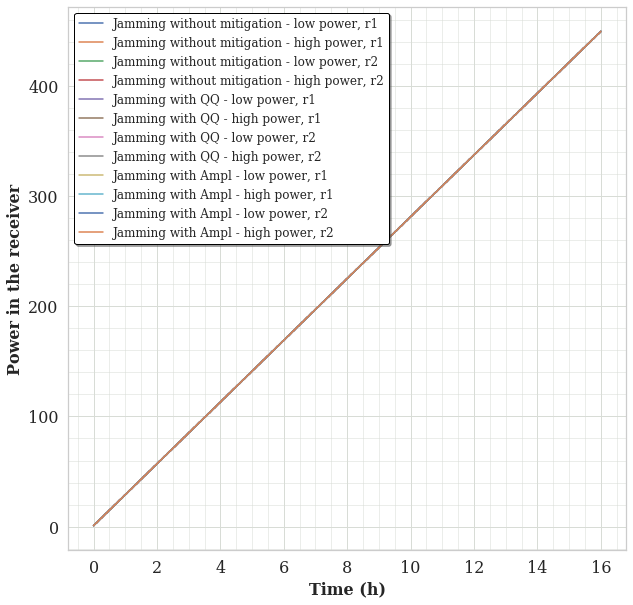

In [33]:
# Power in the receiver (PR)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.plot(t, pr_list, label="Jamming without mitigation - low power, r1")
ax.plot(t, pr1_list, label="Jamming without mitigation - high power, r1")
ax.plot(t, prr_list, label="Jamming without mitigation - low power, r2")
ax.plot(t, pr1r_list, label="Jamming without mitigation - high power, r2")

ax.plot(t, pr_quorum_list, label="Jamming with QQ - low power, r1")
ax.plot(t, pr1_quorum_list, label="Jamming with QQ - high power, r1")
ax.plot(t, prr_quorum_list, label="Jamming with QQ - low power, r2")
ax.plot(t, pr1r_quorum_list, label="Jamming with QQ - high power, r2")

ax.plot(t, pr_amplification_list, label="Jamming with Ampl - low power, r1")
ax.plot(t, pr1_amplification_list, label="Jamming with Ampl - high power, r1")
ax.plot(t, prr_amplification_list, label="Jamming with Ampl - low power, r2")
ax.plot(t, pr1r_amplification_list, label="Jamming with Ampl - high power, r2")

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

ax.set_xlabel('Time (h)',fontweight='bold',fontsize=16)
ax.set_ylabel('Power in the receiver',fontweight='bold',fontsize=16)
ax.tick_params(labelsize=16)
leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=1, frameon='True',fontsize=12)
leg.get_frame().set_edgecolor('black')

#plt.savefig("plots/power_receiver.pdf")
plt.show()

In [ ]:
# SNR
'''
fig, ax = plt.subplots(1, 1, figsize=(10,10))

#ax.plot(t, snrdb_list, label="Jamming without mitigation - low power, r1")
#ax.plot(t, snr1db_list, label="Jamming without mitigation - high power, r1")
#ax.plot(t, snrdbr_list, label="Jamming without mitigation - low power, r2")
ax.plot(t, snr1dbr_list, label="Jamming without mitigation - high power, r2")

#ax.plot(t, snrdb_quorum_list, label="Jamming without QQ - low power, r1")
#ax.plot(t, snr1db_quorum_list, label="Jamming without QQ - high power, r1")
#ax.plot(t, snrdbr_quorum_list, label="Jamming without QQ - low power, r2")
ax.plot(t, snr1dbr_quorum_list, label="Jamming without QQ - high power, r2")

#ax.plot(t, snrdb_amplification_list, label="Jamming without Ampl - low power, r1")
#ax.plot(t, snr1db_amplification_list, label="Jamming without Ampl - high power, r1")
#ax.plot(t, snrdbr_amplification_list, label="Jamming without Ampl - low power, r2")
ax.plot(t, snr1dbr_amplification_list, label="Jamming without Ampl - high power, r2")

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

ax.set_xlabel('Time (h)',fontweight='bold',fontsize=16)
ax.set_ylabel('SNR',fontweight='bold',fontsize=16)
ax.tick_params(labelsize=16)
leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=1, frameon='True',fontsize=12)
leg.get_frame().set_edgecolor('black')
'''

#### Graph 3: DIFFERENT AMPLITUDES (fixed ratio 0.25, fixed High Power, fixed distance r2)
#### Clock: 0 1 0 1 0 1 

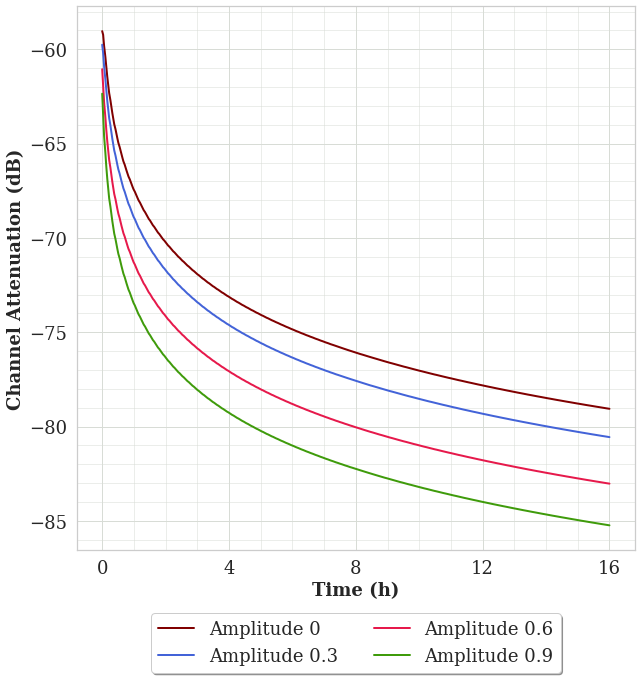

In [34]:
# JN WITHOUT MITIGATION
jn1_results = []
pin_list = []
amplitude_list = [0, 0.3, 0.6, 0.9]
#amplitude_list = [0.1, 0.7, 1, 2]

for amplitude in amplitude_list:
    clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=amplitude, period=1)

    pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)

    pin_list.append(pin_attk)

    jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
    jn_attk = format_output(jn_attk)

    jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
    jn1_attk = format_output(jn1_attk)

    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)
    
    # Old version indicating n_j. Replaced by "t"
    #jn1_results.append([n_j, pldb_list, plj1dbr_list])

    jn1_results.append([t, pldb_list, plj1dbr_list])

# Plot
labels = []
for a in amplitude_list:
    labels.append("Amplitude "+str(a))

#colors = ["#F5793A", "#A95AA1", "#85C0F9", "#0F2080"] 
colors = ["#800000", "#4363d8", "#e6194B", "#3f9b0b"]

plot_jamming_signal_attenuation_specific(jn1_results, labels, colors, "plots/expr3_amplitude.pdf", False, legend_size=18)

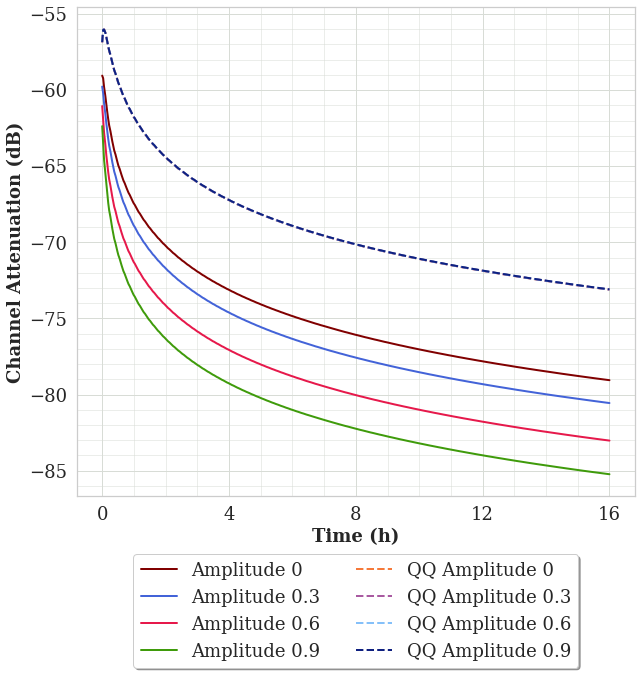

In [35]:
# JN WITH QUORUM QUENCHING MITIGATION
jn1_results = []
jn1_quorum_results = []
pin_list = []
amplitude_list = [0, 0.3, 0.6, 0.9]
#amplitude_list = [0.7, 1, 1.4, 2]

for amplitude in amplitude_list:
    clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=amplitude, period=1)

    pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)

    pin_list.append(pin_attk)

    jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
    jn_attk = format_output(jn_attk)

    jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
    jn1_attk = format_output(jn1_attk)

    jn_attk_quorum = odeint(eqn_JN_quorum,y1_init_quorum,t, args=(pin_attk,pout_attk))
    jn_attk_quorum = format_output(jn_attk_quorum)

    jn1_attk_quorum = odeint(eqn_JN_quorum,y2_init_quorum,t, args=(pin_attk,pout_attk))
    jn1_attk_quorum = format_output(jn1_attk_quorum)

    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)
    n_j, pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list, pr_quorum_list, pr1_quorum_list, prr_quorum_list, pr1r_quorum_list, snrdb_quorum_list, snr1db_quorum_list, snrdbr_quorum_list, snr1dbr_quorum_list, pj_quorum_list, pj1_quorum_list = transmission_interference_signal_without_delay_quorum(jn_attk_quorum, jn1_attk_quorum)
        
    # Old version indicating n_j. Replaced by "t"
    #jn1_results.append([n_j, pldb_list, plj1dbr_list])

    jn1_results.append([t, pldb_list, plj1dbr_list])
    jn1_quorum_results.append([t, pldb_quorum_list, plj1dbr_quorum_list])

# Plot
labels = []
for situation in [0,1]:
    for a in amplitude_list:
        if situation == 1:
            labels.append("QQ Amplitude "+str(a))
        else:
            labels.append("Amplitude "+str(a))

#colors = ["#F5793A", "#A95AA1", "#85C0F9", "#0F2080"] 
colors = ["#800000", "#4363d8", "#e6194B", "#3f9b0b", "#F5793A", "#A95AA1", "#85C0F9", "#0F2080"]

plot_jamming_signal_attenuation_specific_quorum(jn1_results, jn1_quorum_results, labels, colors, "plots/expr3_amplitude_quorum.pdf", False, legend_size=18)

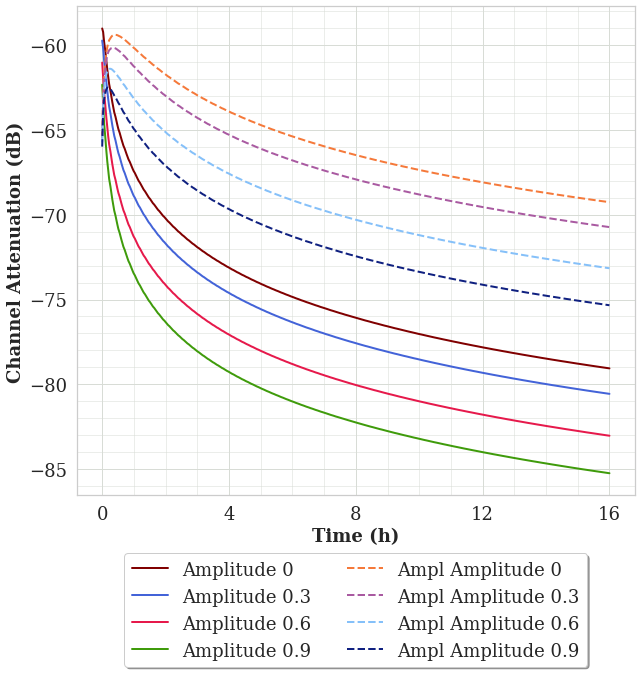

In [36]:
# JN WITH AMPLIFICATION MITIGATION
jn1_results = []
jn1_amplification_results = []
pin_list = []
amplitude_list = [0, 0.3, 0.6, 0.9]

for amplitude in amplitude_list:
    clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=amplitude, period=1)

    pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)

    pin_list.append(pin_attk)

    jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
    jn_attk = format_output(jn_attk)

    jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
    jn1_attk = format_output(jn1_attk)

    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)
    n_j, pldb_amplification_list, pljdb_amplification_list, plj1db_amplification_list, pljdbr_amplification_list, plj1dbr_amplification_list, pr_amplification_list, pr1_amplification_list, prr_amplification_list, pr1r_amplification_list, snrdb_amplification_list, snr1db_amplification_list, snrdbr_amplification_list, snr1dbr_amplification_list, pj_amplification_list, pj1_amplification_list = transmission_interference_signal_without_delay_amplification(jn_attk, jn1_attk)

    
    # Old version indicating n_j. Replaced by "t"
    #jn1_results.append([n_j, pldb_list, plj1dbr_list])

    jn1_results.append([t, pldb_list, plj1dbr_list])
    jn1_amplification_results.append([t, pldb_amplification_list, plj1dbr_amplification_list])

# Plot
labels = []
for situation in [0,1]:
    for a in amplitude_list:
        if situation == 1:
            labels.append("Ampl Amplitude "+str(a))
        else:
            labels.append("Amplitude "+str(a))

#colors = ["#F5793A", "#A95AA1", "#85C0F9", "#0F2080"] 
colors = ["#800000", "#4363d8", "#e6194B", "#3f9b0b", "#F5793A", "#A95AA1", "#85C0F9", "#0F2080"]

plot_jamming_signal_attenuation_specific_amplification(jn1_results, jn1_amplification_results, labels, colors, "plots/expr3_amplitude_amplification.pdf", False, legend_size=18)

#### Graph 4: DIFFERENT PERIODS (fixed ratio 0.25, fixed High Power, fixed distance r2)
#### Signal 1: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
#### Signal 2: [0, 1, 1, 0, 1, 1, 0, 1, 1, 0]
#### Signal 3: [0, 1, 1, 1, 0, 1, 1, 1, 0, 1]
#### Signal 4: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1]

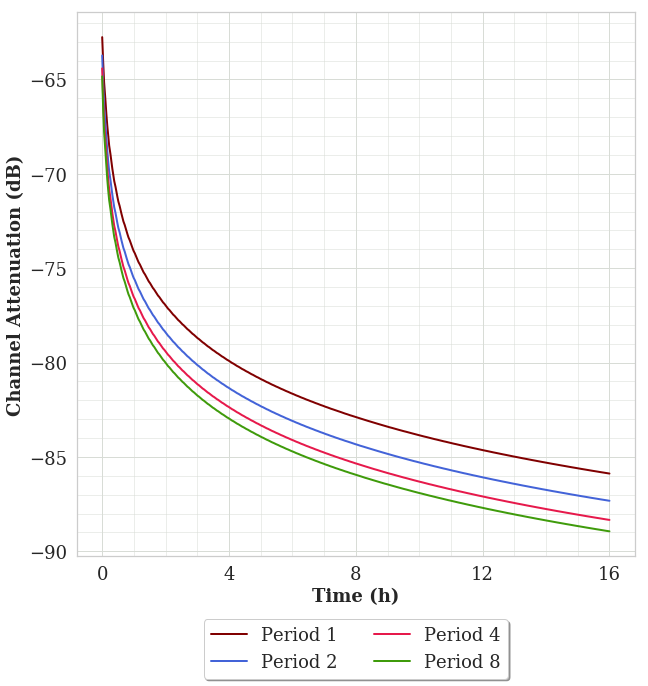

In [94]:
# JN WITHOUT MITIGATION
jn1_results = []
pin_list = []
period_list = [1, 2, 4, 8]

for period in period_list:   
    clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=1, period=period)

    pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)

    pin_list.append(pin_attk)

    jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
    jn_attk = format_output(jn_attk)

    jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
    jn1_attk = format_output(jn1_attk)

    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)

    #jn1_results.append([n_j, pldb_list, plj1dbr_list])
    jn1_results.append([t, pldb_list, plj1dbr_list])


# Plot
labels = []
for p in period_list:
    labels.append("Period "+str(p))

#colors = ["#F5793A", "#A95AA1", "#85C0F9", "#0F2080"] 
colors = ["#800000", "#4363d8", "#e6194B", "#3f9b0b"]

plot_jamming_signal_attenuation_specific(jn1_results, labels, colors, "plots/expr4_period.pdf", False, legend_size=18)

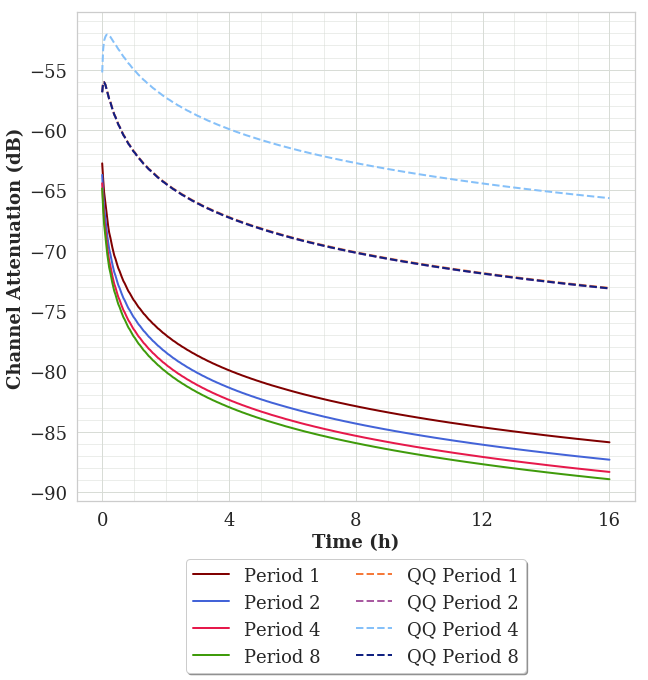

In [95]:
# JN WITH QUORUM QUENCHING MITIGATION
jn1_results = []
jn1_quorum_results = []
pin_list = []
period_list = [1, 2, 4, 8]
#period_list = [1, 2, 4, 100]

for period in period_list:   
    clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=1, period=period)

    pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)
    pin_list.append(pin_attk)

    jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
    jn_attk = format_output(jn_attk)

    jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
    jn1_attk = format_output(jn1_attk)
    
    jn_attk_quorum = odeint(eqn_JN_quorum,y1_init_quorum,t, args=(pin_attk,pout_attk,))
    jn_attk_quorum = format_output(jn_attk_quorum)

    jn1_attk_quorum = odeint(eqn_JN_quorum,y2_init_quorum,t, args=(pin_attk,pout_attk,))
    jn1_attk_quorum = format_output(jn1_attk_quorum)

    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)
    n_j, pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list, pr_quorum_list, pr1_quorum_list, prr_quorum_list, pr1r_quorum_list, snrdb_quorum_list, snr1db_quorum_list, snrdbr_quorum_list, snr1dbr_quorum_list, pj_quorum_list, pj1_quorum_list = transmission_interference_signal_without_delay_quorum(jn_attk_quorum, jn1_attk_quorum)
    
    #jn1_results.append([n_j, pldb_list, plj1dbr_list])
    jn1_results.append([t, pldb_list, plj1dbr_list])
    jn1_quorum_results.append([t, pldb_quorum_list, plj1dbr_quorum_list])


# Plot
labels = []
for situation in [0,1]:
    for p in period_list:
        if situation == 1:
            labels.append("QQ Period "+str(p))
        else:
            labels.append("Period "+str(p))

#colors = ["#F5793A", "#A95AA1", "#85C0F9", "#0F2080"] 
colors = ["#800000", "#4363d8", "#e6194B", "#3f9b0b", "#F5793A", "#A95AA1", "#85C0F9", "#0F2080"]

plot_jamming_signal_attenuation_specific_quorum(jn1_results, jn1_quorum_results, labels, colors, "plots/expr4_period_quorum.pdf", False, legend_size=18)

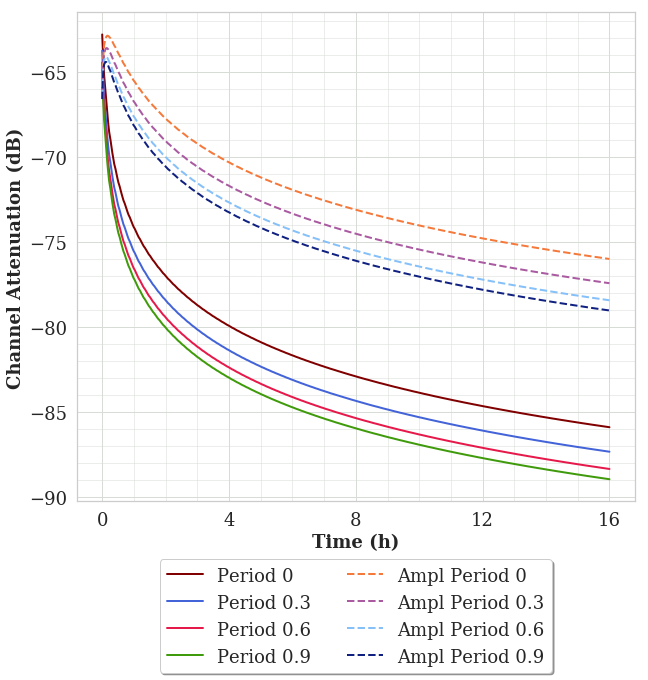

In [96]:
# JN WITH AMPLIFICATION MITIGATION
jn1_results = []
jn1_amplification_results = []

pin_list = []
period_list = [1, 2, 4, 8]

for period in period_list:   
    clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=1, period=period)

    pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)

    pin_list.append(pin_attk)

    jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
    jn_attk = format_output(jn_attk)

    jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
    jn1_attk = format_output(jn1_attk)

    n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)
    n_j, pldb_amplification_list, pljdb_amplification_list, plj1db_amplification_list, pljdbr_amplification_list, plj1dbr_amplification_list, pr_amplification_list, pr1_amplification_list, prr_amplification_list, pr1r_amplification_list, snrdb_amplification_list, snr1db_amplification_list, snrdbr_amplification_list, snr1dbr_amplification_list, pj_amplification_list, pj1_amplification_list = transmission_interference_signal_without_delay_amplification(jn_attk, jn1_attk)
    
    #jn1_results.append([n_j, pldb_list, plj1dbr_list])
    jn1_results.append([t, pldb_list, plj1dbr_list])
    jn1_amplification_results.append([t, pldb_amplification_list, plj1dbr_amplification_list])

# Plot
labels = []
for situation in [0,1]:
    for a in amplitude_list:
        if situation == 1:
            labels.append("Ampl Period "+str(a))
        else:
            labels.append("Period "+str(a))

#colors = ["#F5793A", "#A95AA1", "#85C0F9", "#0F2080"] 
colors = ["#800000", "#4363d8", "#e6194B", "#3f9b0b", "#F5793A", "#A95AA1", "#85C0F9", "#0F2080"]

plot_jamming_signal_attenuation_specific_amplification(jn1_results, jn1_amplification_results, labels, colors, "plots/expr4_period_amplification.pdf", False, legend_size=18)

#### Graph 5: DIFFERENT AMPLITUDES AND PERIODS (fixed ratio 0.25, fixed High Power, fixed distance r2)

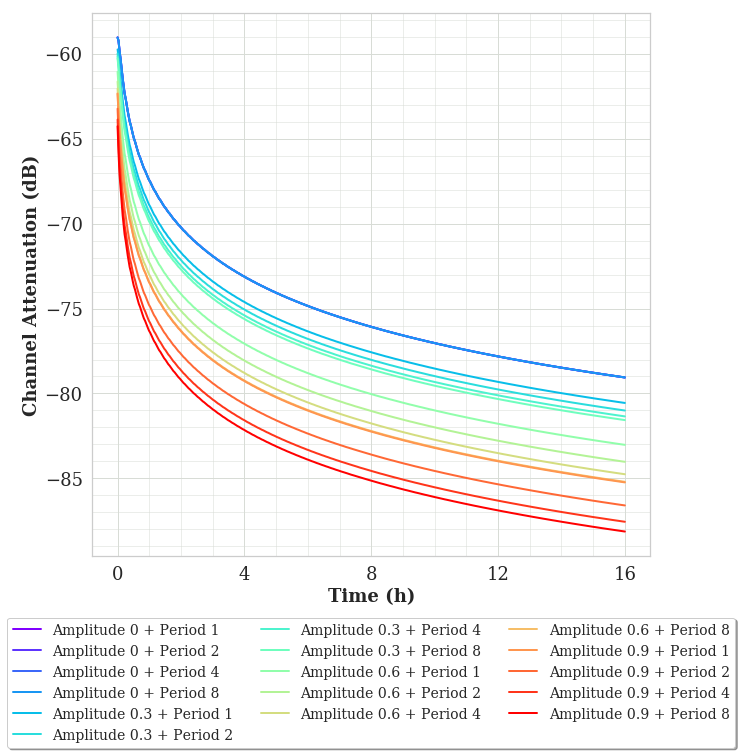

In [97]:
# JN WITHOUT MITIGATION
jn1_results = []
pin_list = []
amplitude_list = [0, 0.3, 0.6, 0.9]
period_list = [1, 2, 4, 8]

for amplitude in amplitude_list:
    for period in period_list:   
        clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=amplitude, period=period)

        pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)

        pin_list.append(pin_attk)

        jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
        jn_attk = format_output(jn_attk)

        jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
        jn1_attk = format_output(jn1_attk)

        n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)

        #jn1_results.append([n_j, pldb_list, plj1dbr_list])
        jn1_results.append([t, pldb_list, plj1dbr_list])

    
# Plot
labels = []
for a in amplitude_list:
    for p in period_list:
        labels.append("Amplitude "+str(a)+" + Period "+str(p))

#from matplotlib.pyplot import cm
#colors = []

#n_colors = len(amplitude_list)*len(period_list)
#color=iter(cm.rainbow(np.linspace(0,1,n_colors)))

#for i in range(n_colors):
#   c=next(color)
#   colors.append(c)

'''
# Rainbow colors
colors = ["#800000", "#e6194B", "#fabebe", "#9A6324", "#f58231", "#ffd8b1", 
          "#808000", "#ffe119", "#fffac8", "#bfef45", "#3cb44b", "#aaffc3", 
          "#469990", "#42d4f4", "#000075", "#4363d8"]

plot_jamming_signal_attenuation_specific(jn1_results, labels, colors, "plots/expr5_distinct_colors.pdf", False, legend_size=12)
'''

# Other set of colors
from matplotlib.pyplot import cm
colors = []
n_colors = len(amplitude_list)*len(period_list)
color=iter(cm.rainbow(np.linspace(0,1,n_colors)))

for i in range(n_colors):
   c=next(color)
   colors.append(c)
    
plot_jamming_signal_attenuation_specific(jn1_results, labels, colors, "plots/expr5_amplitude_period.pdf", False, legend_size=14, n_cols=3)

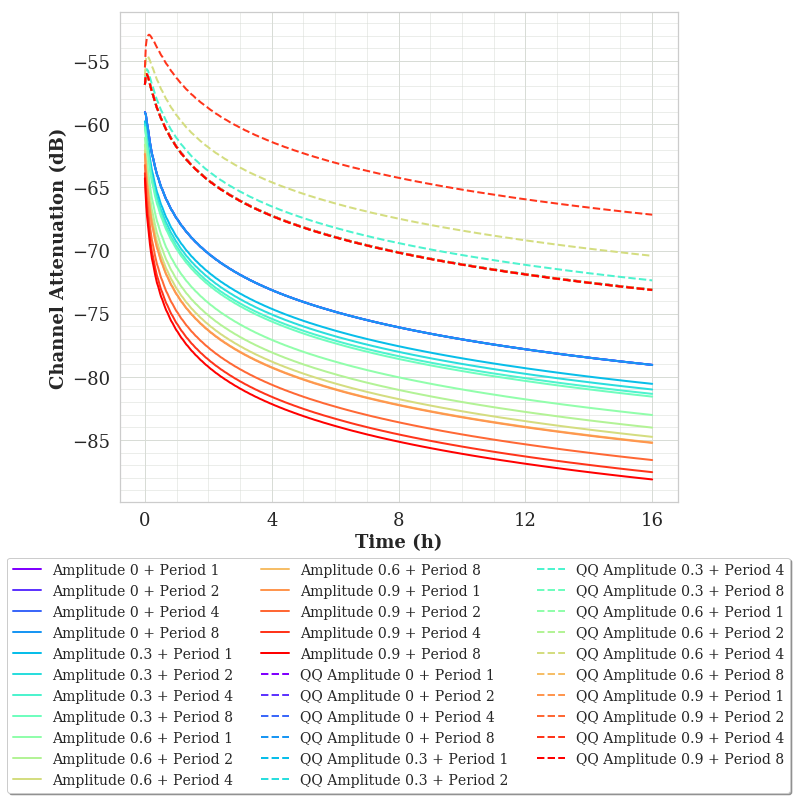

In [98]:
# JN WITH QUORUM QUENCHING MITIGATION
jn1_results = []
jn1_quorum_results = []
pin_list = []
amplitude_list = [0, 0.3, 0.6, 0.9]
period_list = [1, 2, 4, 8]

for amplitude in amplitude_list:
    for period in period_list:   
        clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=amplitude, period=period)

        pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)

        pin_list.append(pin_attk)

        jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
        jn_attk = format_output(jn_attk)

        jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
        jn1_attk = format_output(jn1_attk)
        
        jn_attk_quorum = odeint(eqn_JN_quorum,y1_init_quorum,t, args=(pin_attk,pout_attk,))
        jn_attk_quorum = format_output(jn_attk_quorum)

        jn1_attk_quorum = odeint(eqn_JN_quorum,y2_init_quorum,t, args=(pin_attk,pout_attk,))
        jn1_attk_quorum = format_output(jn1_attk_quorum)

        n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)
        n_j, pldb_quorum_list, pljdb_quorum_list, plj1db_quorum_list, pljdbr_quorum_list, plj1dbr_quorum_list, pr_quorum_list, pr1_quorum_list, prr_quorum_list, pr1r_quorum_list, snrdb_quorum_list, snr1db_quorum_list, snrdbr_quorum_list, snr1dbr_quorum_list, pj_quorum_list, pj1_quorum_list = transmission_interference_signal_without_delay_quorum(jn_attk_quorum, jn1_attk_quorum)

        #jn1_results.append([n_j, pldb_list, plj1dbr_list])
        jn1_results.append([t, pldb_list, plj1dbr_list])
        jn1_quorum_results.append([t, pldb_quorum_list, plj1dbr_quorum_list])
    
# Plot
labels = []
for situation in [0,1]:
    for a in amplitude_list:
        for p in period_list:
            if situation == 1:
                labels.append("QQ Amplitude "+str(a)+" + Period "+str(p))
            else:
                labels.append("Amplitude "+str(a)+" + Period "+str(p))

#from matplotlib.pyplot import cm
#colors = []

#n_colors = len(amplitude_list)*len(period_list)
#color=iter(cm.rainbow(np.linspace(0,1,n_colors)))

#for i in range(n_colors):
#   c=next(color)
#   colors.append(c)
'''
# Rainbow colors
colors = ["#800000", "#e6194B", "#fabebe", "#9A6324", "#f58231", "#ffd8b1", 
          "#808000", "#ffe119", "#fffac8", "#bfef45", "#3cb44b", "#aaffc3", 
          "#469990", "#42d4f4", "#000075", "#4363d8",
         
         "#800000", "#e6194B", "#fabebe", "#9A6324", "#f58231", "#ffd8b1", 
          "#808000", "#ffe119", "#fffac8", "#bfef45", "#3cb44b", "#aaffc3", 
          "#469990", "#42d4f4", "#000075", "#4363d8"]

plot_jamming_signal_attenuation_specific_quorum(jn1_results, jn1_quorum_results, labels, colors, "plots/expr5_distinct_colors_quorum.pdf", False, legend_size=8, n_cols=2)
'''

# Other set of colors
from matplotlib.pyplot import cm
colors = []
n_colors = len(amplitude_list)*len(period_list)
color=iter(cm.rainbow(np.linspace(0,1,n_colors)))

for i in range(n_colors):
   c=next(color)
   colors.append(c)

# duplicate content in colors array
colors_copy = []
for c in colors:
    colors_copy.append(c)
    
for c in colors_copy:
    colors.append(c)
    
plot_jamming_signal_attenuation_specific_quorum(jn1_results, jn1_quorum_results, labels, colors, "plots/expr5_amplitude_period_quorum.pdf", False, legend_size=14, n_cols=3)

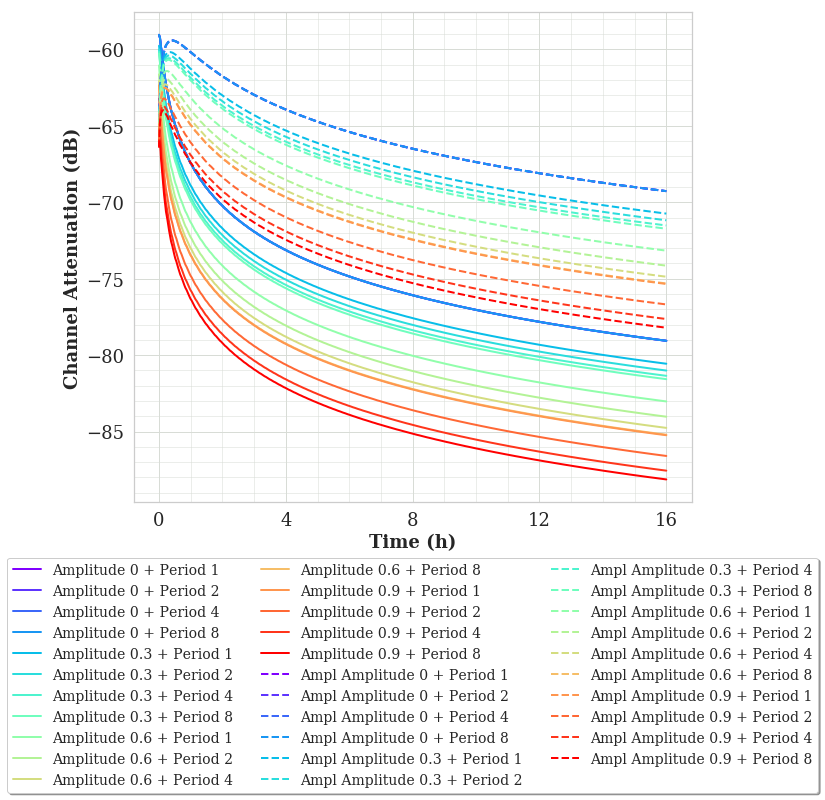

In [99]:
# JN WITH AMPLIFICATION MITIGATION
jn1_results = []
jn1_amplification_results = []
pin_list = []
amplitude_list = [0, 0.3, 0.6, 0.9]
period_list = [1, 2, 4, 8]

for amplitude in amplitude_list:
    for period in period_list:   
        clock_signal_attk, amplitude_signal_attk, period_signal_attk = generate_clock_signal(amplitude=amplitude, period=period)

        pin_attk, pout_attk = generate_pin_pout_arrays(clock_signal_attk, amplitude_signal_attk)

        pin_list.append(pin_attk)

        jn_attk = odeint(eqn_JN,y1_init,t, args=(pin_attk,pout_attk,))
        jn_attk = format_output(jn_attk)

        jn1_attk = odeint(eqn_JN,y2_init,t, args=(pin_attk,pout_attk,))
        jn1_attk = format_output(jn1_attk)

        n_j, pldb_list, pljdb_list, plj1db_list, pljdbr_list, plj1dbr_list, pr_list, pr1_list, prr_list, pr1r_list, snrdb_list, snr1db_list, snrdbr_list, snr1dbr_list, pj_list, pj1_list, p_noise_list = transmission_interference_signal_without_delay(jn_attk, jn1_attk)
        n_j, pldb_amplification_list, pljdb_amplification_list, plj1db_amplification_list, pljdbr_amplification_list, plj1dbr_amplification_list, pr_amplification_list, pr1_amplification_list, prr_amplification_list, pr1r_amplification_list, snrdb_amplification_list, snr1db_amplification_list, snrdbr_amplification_list, snr1dbr_amplification_list, pj_amplification_list, pj1_amplification_list = transmission_interference_signal_without_delay_amplification(jn_attk, jn1_attk)

        #jn1_results.append([n_j, pldb_list, plj1dbr_list])
        jn1_results.append([t, pldb_list, plj1dbr_list])
        jn1_amplification_results.append([t, pldb_amplification_list, plj1dbr_amplification_list])
    
# Plot
labels = []
for situation in [0,1]:
    for a in amplitude_list:
        for p in period_list:
            if situation == 1:
                labels.append("Ampl Amplitude "+str(a)+" + Period "+str(p))
            else:
                labels.append("Amplitude "+str(a)+" + Period "+str(p))

#from matplotlib.pyplot import cm
#colors = []

#n_colors = len(amplitude_list)*len(period_list)
#color=iter(cm.rainbow(np.linspace(0,1,n_colors)))

#for i in range(n_colors):
#   c=next(color)
#   colors.append(c)

'''
# Rainbow colors
colors = ["#800000", "#e6194B", "#fabebe", "#9A6324", "#f58231", "#ffd8b1", 
          "#808000", "#ffe119", "#fffac8", "#bfef45", "#3cb44b", "#aaffc3", 
          "#469990", "#42d4f4", "#000075", "#4363d8",
         
         "#800000", "#e6194B", "#fabebe", "#9A6324", "#f58231", "#ffd8b1", 
          "#808000", "#ffe119", "#fffac8", "#bfef45", "#3cb44b", "#aaffc3", 
          "#469990", "#42d4f4", "#000075", "#4363d8"]

plot_jamming_signal_attenuation_specific_amplification(jn1_results, jn1_amplification_results, labels, colors, "plots/expr5_distinct_colors_amplification.pdf", False, legend_size=8, n_cols=2)
'''

# Other set of colors
from matplotlib.pyplot import cm
colors = []
n_colors = len(amplitude_list)*len(period_list)
color=iter(cm.rainbow(np.linspace(0,1,n_colors)))

for i in range(n_colors):
   c=next(color)
   colors.append(c)

# duplicate content in colors array
colors_copy = []
for c in colors:
    colors_copy.append(c)
    
for c in colors_copy:
    colors.append(c)
    
plot_jamming_signal_attenuation_specific_amplification(jn1_results, jn1_amplification_results, labels, colors, "plots/expr5_amplitude_period_amplification.pdf", False, legend_size=14, n_cols=3)

#### Plot 1: Analysis of the relationship between pin and pout

In [ ]:
import csv
import pandas as pd

In [ ]:
def append_to_csv_file(filename, line):
    # Update the attack file
    with open(filename, 'a') as csvFile:
        writer = csv.writer(csvFile, delimiter=';')
        writer.writerow(line)

In [ ]:
csv_filename = "parameters_evaluation.csv"
header = ["pin", "pout", "ratio_in_out","t_index", "t_instant", "eq_result"]

# Overwrite CSV file and write header
open(csv_filename, 'w').close() # Remove file content
append_to_csv_file(csv_filename, header)

In [ ]:
range_values = np.linspace(0.1,0.4,10).round(2)
range_values

In [ ]:
T_INSTANTS = 4
y0 = [2,0.15,0,0,0.1]
t = np.linspace(0,16,num=T_INSTANTS).round(2)

In [ ]:
t

In [ ]:
range_values

In [ ]:
for pin in range_values:
    for pout in range_values:
        eq_result = odeint(eqn_TN,y1,t,args=(pin,pout,))
        print(eq_result)
        print("")
        # Each instant of time evaluated
        
        if pin == 0.0:
            ratio = 0.0
        else:
            ratio = pin/pout
        
        # For each instant of time evaluated, we only get the result of the last equation
        # We write the line to the output CSV file
        for t_instant in range(0, T_INSTANTS):
            append_to_csv_file(csv_filename, [str(pin), str(pout), str(ratio), str(t_instant), str(t[t_instant]), str(eq_result[t_instant][4])])

In [ ]:
df = pd.read_csv(csv_filename, delimiter=";")

In [ ]:
df.head()

In [ ]:
df.ratio_in_out.unique()

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="ratio_in_out", y="eq_result", data=df[(df.t_index == 3) & (df.ratio_in_out < 2.1)], label="t=16h", linewidth=2.0)
ax = sns.lineplot(x="ratio_in_out", y="eq_result", data=df[(df.t_index == 2) & (df.ratio_in_out < 2.1)], label="t=11h", linewidth=2.0)
ax = sns.lineplot(x="ratio_in_out", y="eq_result", data=df[(df.t_index == 1) & (df.ratio_in_out < 2.1)], label="t=5.3h", linewidth=2.0)
ax = sns.lineplot(x="ratio_in_out", y="eq_result", data=df[(df.t_index == 0) & (df.ratio_in_out < 2.1)], label="t=0h", linewidth=2.0)

ax.tick_params(labelsize=16)
#ax.set(xlabel='Ratio pin/pout', ylabel='Amount of molecules')#, title="Evolution of the ratio pin/pout")

ax.set_xlabel("Ratio pin/pout",fontsize=16, fontweight='bold')
ax.set_ylabel("Molecular concentration (\u03BCMol/V)",fontsize=15, fontweight='bold')

eg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=1, frameon='True',fontsize=16)
fig.savefig("plots/expr1_ratio.pdf")

In [ ]:
T_INSTANTS = 500

# SNR analysis

### Variation of proportion DN (amplification)

In [ ]:
# Base situation (amplitude 1)

# TN initialization values
y0 = [2,0.15,0,0,0.1]

# JN initialization values
y1 = [0.2,0.15,0,0,0.01]
y2 = [1,0.15,0,0,0.01]

clock_signal_base, amplitude_signal_base, period_signal_base = generate_clock_signal(amplitude=1, period=1)
pin_base, pout_base = generate_pin_pout_arrays(clock_signal_base, amplitude_signal_base)

y1_init = tile(array(y1),T_INSTANTS)
y2_init = tile(array(y2),T_INSTANTS)

# TN simulation
tn = odeint(eqn_TN,y0,t,args=(0.1,0.1,))

# JN simulation without mitigation
# jn: low power
jn = odeint(eqn_JN,y1_init,t, args=(pin_base, pout_base))
jn = format_output(jn)

# jn1: high power
jn1 = odeint(eqn_JN,y2_init,t, args=(pin_base, pout_base))
jn1 = format_output(jn1)

# Calculation of power and SNR

n_t = 500
n_j = 500

proportion_DN = []

for proportion in range(1, 101):
    proportion_DN.append(proportion)

pt_amplification_list = []
pj_amplification_list = []
pj1_amplification_list = []
pjr_amplification_list = []
pj1r_amplification_list = []

st_list = []
sj_list = []
sj1_list = []
sjr_list = []
sj1r_list = []

snrdb_amplification_list = []
snr1db_amplification_list = []
snrdbr_amplification_list = []
snr1dbr_amplification_list = []

r=0.0005 #5um
# Daniel's distance values
#r1=0.5 #5000um
#r2=0.05 #500um

r1=1 #10000um
r2=0.05 #500um
v=np.sqrt(2)/2

hj=1/(1+np.exp((r1-v*t)/np.sqrt(2)))
hj1=1/(1+np.exp((r2-v*t)/np.sqrt(2)))

ht_list = []

'''
# CALCULATION OF THE SNR FROM THE TRANSMITTER POINT OF VIEW
for proportion in range(1, 101):
    
    # TN POPULATION    
    pt_amplification = proportion * n_t * (np.sum(np.linalg.norm(tn[:,4])**2)/(len(tn[:,4])))
    pt_amplification_list.append(pt_amplification)
    
    # JN POPULATION
    pj = n_j * (np.sum(np.linalg.norm(jn[:,4])**2)/(len(jn[:,4])))
    pj1 = n_j * (np.sum(np.linalg.norm(jn1[:,4])**2)/(len(jn1[:,4])))
    pj_amplification_list.append(pj)
    pj1_amplification_list.append(pj1)

    snr = pt_amplification_list[proportion-1]/(pj_amplification_list[proportion-1]+0.3)#p_noise_list[ii])
    snr1 = pt_amplification_list[proportion-1]/(pj1_amplification_list[proportion-1]+0.3)#p_noise_list[ii])
    snrdb_amplification_list.append(10*np.log10(snr))
    snr1db_amplification_list.append(10*np.log10(snr1))
'''   

# CALCULATION OF THE SNR FROM THE RECEIVER POINT OF VIEW
for proportion in range(1, 101):
    
    for ii in range(0,T_INSTANTS):
        ht=1/(1+np.exp((r-v*t[ii])/np.sqrt(2))) # equation (7)
        ht_list.append(ht)

        s=n_t*np.convolve(ht_list[ii],tn[:,4],'same')
        st = s*(1+proportion)
        st_list.append(st)
        
        # Distance 1
        sj = (n_j*np.convolve(hj,jn[:,4],'same'))
        sj1 = (n_j*np.convolve(hj,jn1[:,4],'same'))
        sj_list.append(sj)
        sj1_list.append(sj1)
        
        # Distance 2
        sjr = (n_j*np.convolve(hj1,jn[:,4],'same'))
        sj1r = (n_j*np.convolve(hj1,jn1[:,4],'same'))
        sjr_list.append(sjr)
        sj1r_list.append(sj1r)
    
    # TN POPULATION    
    pt_amplification = proportion * (np.sum(np.linalg.norm(np.array(st_list)**2)/(len(st_list))))
    pt_amplification_list.append(pt_amplification)
    
    # JN POPULATION
    
    # Distance 1
    pj = (np.sum(np.linalg.norm(sj_list)**2)/(len(sj_list)))
    pj1 = (np.sum(np.linalg.norm(sj1_list)**2)/(len(sj1_list)))
    pj_amplification_list.append(pj)
    pj1_amplification_list.append(pj1)
    
    snr = pt_amplification_list[proportion-1]/(pj_amplification_list[proportion-1]+0.3)#p_noise_list[ii])
    snr1 = pt_amplification_list[proportion-1]/(pj1_amplification_list[proportion-1]+0.3)#p_noise_list[ii])
    snrdb_amplification_list.append(10*np.log10(snr))
    snr1db_amplification_list.append(10*np.log10(snr1))
    
    # Distance 2
    pjr = (np.sum(np.linalg.norm(sjr_list)**2)/(len(sjr_list)))
    pj1r = (np.sum(np.linalg.norm(sj1r_list)**2)/(len(sj1r_list)))
    pjr_amplification_list.append(pjr)
    pj1r_amplification_list.append(pj1r)
    
    snrr = pt_amplification_list[proportion-1]/(pjr_amplification_list[proportion-1]+0.3)#p_noise_list[ii])
    snr1r = pt_amplification_list[proportion-1]/(pj1r_amplification_list[proportion-1]+0.3)#p_noise_list[ii])
    snrdbr_amplification_list.append(10*np.log10(snrr))
    snr1dbr_amplification_list.append(10*np.log10(snr1r))

In [ ]:
# SNR AMPLIFICATION
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.plot(proportion_DN, snrdb_amplification_list, label="Jamming with Ampl - low power, r1")
ax.plot(proportion_DN, snr1db_amplification_list, label="Jamming with Ampl - high power, r1")
ax.plot(proportion_DN, snrdbr_amplification_list, label="Jamming with Ampl - low power, r2")
ax.plot(proportion_DN, snr1dbr_amplification_list, label="Jamming with Ampl - high power, r2")

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

ax.set_xlabel('Proportion DN',fontweight='bold',fontsize=16)
ax.set_ylabel('SNR',fontweight='bold',fontsize=16)
ax.tick_params(labelsize=16)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=14)

#leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=1, frameon='True',fontsize=12)
#leg.get_frame().set_edgecolor('black')

fig.savefig("plots/SNR_amplification_proportion.pdf")
plt.show()

### Variation of K and L parameters (QQ)

In [ ]:
# Base situation (amplitude 1)

# TN initialization values
y0 = [2,0.15,0,0,0.1]

# JN initialization values
y1 = [0.2,0.15,0,0,0.01]
y2 = [1,0.15,0,0,0.01]

# JN initialization values with quorum quenching mitigation
y1_quorum = [0.2,0.15,0,0,0.1,0.1,0.075] # A_ and R_ are initialized as half of the values of A and R, respectively
y2_quorum = [1,0.15,0,0,0.1,0.5,0.075]

clock_signal_base, amplitude_signal_base, period_signal_base = generate_clock_signal(amplitude=1, period=1)
pin_base, pout_base = generate_pin_pout_arrays(clock_signal_base, amplitude_signal_base)

y1_init = tile(array(y1),T_INSTANTS)
y2_init = tile(array(y2),T_INSTANTS)

y1_init_quorum = tile(array(y1_quorum),T_INSTANTS)
y2_init_quorum = tile(array(y2_quorum),T_INSTANTS)

# TN simulation
tn = odeint(eqn_TN,y0,t,args=(0.1,0.1,))

# Calculation of power and SNR

n_t = 500
n_j = 500

values_l_list = []
values_k_list = []

for k in np.arange(2e-12, 2e-4, 2e-6):
    values_k_list.append(k)
    
for l in np.arange(1e-6, 1e+2, 1):
    values_l_list.append(l)


pt_quorum_list = []
pj_quorum_list = []
pj1_quorum_list = []
pjr_quorum_list = []
pj1r_quorum_list = []

st_quorum_list = []
sj_quorum_list = []
sj1_quorum_list = []
sjr_quorum_list = []
sj1r_quorum_list = []

snrdb_quorum_list_l = []
snr1db_quorum_list_l = []
snrdbr_quorum_list_l = []
snr1dbr_quorum_list_l = []

snrdb_quorum_list_k = []
snr1db_quorum_list_k = []
snrdbr_quorum_list_k = []
snr1dbr_quorum_list_k = []

r=0.0005 #5um
# Daniel's distance values
#r1=0.5 #5000um
#r2=0.05 #500um

r1=1 #10000um
r2=0.05 #500um
v=np.sqrt(2)/2

hj=1/(1+np.exp((r1-v*t)/np.sqrt(2)))
hj1=1/(1+np.exp((r2-v*t)/np.sqrt(2)))

ht_list = []  

k_base = 2e-8
l_base = 1e-2


# L PARAMETER: CALCULATION OF THE SNR FROM THE RECEIVER POINT OF VIEW
for l_index in range(0, len(values_l_list)):
    print(l_index)
    # JN simulation with quorum quenching mitigation
    jn_quorum = odeint(eqn_JN_quorum,y1_init_quorum,t, args=(pin_base, pout_base, k_base, k_base, values_l_list[l_index], values_l_list[l_index]))
    jn_quorum = format_output(jn_quorum)

    jn1_quorum = odeint(eqn_JN_quorum,y2_init_quorum,t, args=(pin_base, pout_base, k_base, k_base, values_l_list[l_index], values_l_list[l_index]))
    jn1_quorum = format_output(jn1_quorum)
    
    for ii in range(0,T_INSTANTS):
        ht=1/(1+np.exp((r-v*t[ii])/np.sqrt(2))) # equation (7)
        ht_list.append(ht)

        s=n_t*np.convolve(ht_list[ii],tn[:,4],'same')
        st_quorum_list.append(s)
        
        # Distance 1
        sj = (n_j*np.convolve(hj,jn_quorum[:,4],'same'))
        sj1 = (n_j*np.convolve(hj,jn1_quorum[:,4],'same'))
        sj_quorum_list.append(sj)
        sj1_quorum_list.append(sj1)
        
        # Distance 2
        sjr = (n_j*np.convolve(hj1,jn_quorum[:,4],'same'))
        sj1r = (n_j*np.convolve(hj1,jn1_quorum[:,4],'same'))
        sjr_quorum_list.append(sjr)
        sj1r_quorum_list.append(sj1r)
    
    # TN POPULATION    
    pt_quorum = (np.sum(np.linalg.norm(np.array(st_quorum_list)**2)/(len(st_quorum_list))))
    pt_quorum_list.append(pt_quorum)
    
    # JN POPULATION
    
    # Distance 1
    pj = (np.sum(np.linalg.norm(sj_quorum_list)**2)/(len(sj_quorum_list)))
    pj1 = (np.sum(np.linalg.norm(sj1_quorum_list)**2)/(len(sj1_quorum_list)))
    pj_quorum_list.append(pj)
    pj1_quorum_list.append(pj1)
    
    snr = pt_quorum_list[l_index]/(pj_quorum_list[l_index]+0.3)#p_noise_list[ii])
    snr1 = pt_quorum_list[l_index]/(pj1_quorum_list[l_index]+0.3)#p_noise_list[ii])
    snrdb_quorum_list_l.append(10*np.log10(snr))
    snr1db_quorum_list_l.append(10*np.log10(snr1))
    
    # Distance 2
    pjr = (np.sum(np.linalg.norm(sjr_quorum_list)**2)/(len(sjr_quorum_list)))
    pj1r = (np.sum(np.linalg.norm(sj1r_quorum_list)**2)/(len(sj1r_quorum_list)))
    pjr_quorum_list.append(pjr)
    pj1r_quorum_list.append(pj1r)
    
    snrr = pt_quorum_list[l_index]/(pjr_quorum_list[l_index]+0.3)#p_noise_list[ii])
    snr1r = pt_quorum_list[l_index]/(pj1r_quorum_list[l_index]+0.3)#p_noise_list[ii])
    snrdbr_quorum_list_l.append(10*np.log10(snrr))
    snr1dbr_quorum_list_l.append(10*np.log10(snr1r))


pt_quorum_list = []
pj_quorum_list = []
pj1_quorum_list = []
pjr_quorum_list = []
pj1r_quorum_list = []

st_quorum_list = []
sj_quorum_list = []
sj1_quorum_list = []
sjr_quorum_list = []
sj1r_quorum_list = []

print("----")
# K PARAMETER: CALCULATION OF THE SNR FROM THE RECEIVER POINT OF VIEW
for k_index in range(0, len(values_k_list)):
    print(k_index)
    # JN simulation with quorum quenching mitigation
    jn_quorum = odeint(eqn_JN_quorum,y1_init_quorum,t, args=(pin_base, pout_base, values_k_list[k_index], values_k_list[k_index], l_base, l_base))
    jn_quorum = format_output(jn_quorum)

    jn1_quorum = odeint(eqn_JN_quorum,y2_init_quorum,t, args=(pin_base, pout_base, values_k_list[k_index], values_k_list[k_index], l_base, l_base))
    jn1_quorum = format_output(jn1_quorum)
    
    for ii in range(0,T_INSTANTS):
        ht=1/(1+np.exp((r-v*t[ii])/np.sqrt(2))) # equation (7)
        ht_list.append(ht)

        s=n_t*np.convolve(ht_list[ii],tn[:,4],'same')
        st_quorum_list.append(s)
        
        # Distance 1
        sj = (n_j*np.convolve(hj,jn_quorum[:,4],'same'))
        sj1 = (n_j*np.convolve(hj,jn1_quorum[:,4],'same'))
        sj_quorum_list.append(sj)
        sj1_quorum_list.append(sj1)
        
        # Distance 2
        sjr = (n_j*np.convolve(hj1,jn_quorum[:,4],'same'))
        sj1r = (n_j*np.convolve(hj1,jn1_quorum[:,4],'same'))
        sjr_quorum_list.append(sjr)
        sj1r_quorum_list.append(sj1r)           
    
    
    # TN POPULATION    
    pt_quorum = (np.sum(np.linalg.norm(np.array(st_quorum_list)**2)/(len(st_quorum_list))))
    pt_quorum_list.append(pt_quorum)
    
    # JN POPULATION
    
    # Distance 1
    pj = (np.sum(np.linalg.norm(sj_quorum_list)**2)/(len(sj_quorum_list)))
    pj1 = (np.sum(np.linalg.norm(sj1_quorum_list)**2)/(len(sj1_quorum_list)))
    pj_quorum_list.append(pj)
    pj1_quorum_list.append(pj1)
    
    snr = pt_quorum_list[k_index]/(pj_quorum_list[k_index]+0.3)#p_noise_list[ii])
    snr1 = pt_quorum_list[k_index]/(pj1_quorum_list[k_index]+0.3)#p_noise_list[ii])
    snrdb_quorum_list_k.append(10*np.log10(snr))
    snr1db_quorum_list_k.append(10*np.log10(snr1))
    
    # Distance 2
    pjr = (np.sum(np.linalg.norm(sjr_quorum_list)**2)/(len(sjr_quorum_list)))
    pj1r = (np.sum(np.linalg.norm(sj1r_quorum_list)**2)/(len(sj1r_quorum_list)))
    pjr_quorum_list.append(pjr)
    pj1r_quorum_list.append(pj1r)
    
    snrr = pt_quorum_list[k_index]/(pjr_quorum_list[k_index]+0.3)#p_noise_list[ii])
    snr1r = pt_quorum_list[k_index]/(pj1r_quorum_list[k_index]+0.3)#p_noise_list[ii])
    snrdbr_quorum_list_k.append(10*np.log10(snrr))
    snr1dbr_quorum_list_k.append(10*np.log10(snr1r))


In [ ]:
aa = []
for k in np.arange(1e-6, 1e+2, 10):
    aa.append(k)
    
print(len(aa))

In [ ]:
# SNR L PARAMETER
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.plot(values_l_list, snrdb_quorum_list_l, label="Jamming with QQ - low power, r1")
ax.plot(values_l_list, snr1db_quorum_list_l, label="Jamming with QQ - high power, r1")
ax.plot(values_l_list, snrdbr_quorum_list_l, label="Jamming with QQ - low power, r2")
ax.plot(values_l_list, snr1dbr_quorum_list_l, label="Jamming with QQ - high power, r2")

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

ax.set_xlabel('L parameter',fontweight='bold',fontsize=16)
ax.set_ylabel('SNR',fontweight='bold',fontsize=16)
ax.tick_params(labelsize=16)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
             box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
      fancybox=True, shadow=True, ncol=2, fontsize=14)

#leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=1, frameon='True',fontsize=12)
#leg.get_frame().set_edgecolor('black')

fig.savefig("plots/SNR_QQ_L_parameter.pdf")
fig.show()

In [ ]:
# SNR K PARAMETER
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.plot(values_k_list, snrdb_quorum_list_k, label="Jamming with QQ - low power, r1")
ax.plot(values_k_list, snr1db_quorum_list_k, label="Jamming with QQ - high power, r1")
ax.plot(values_k_list, snrdbr_quorum_list_k, label="Jamming with QQ - low power, r2")
ax.plot(values_k_list, snr1dbr_quorum_list_k, label="Jamming with QQ - high power, r2")

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

ax.set_xlabel('K parameter',fontweight='bold',fontsize=16)
ax.set_ylabel('SNR',fontweight='bold',fontsize=16)
ax.tick_params(labelsize=16)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=14)

#leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=1, frameon='True',fontsize=12)
#leg.get_frame().set_edgecolor('black')

fig.savefig("plots/SNR_QQ_K_parameter.pdf")
fig.show()

In [ ]:
'''
# Base situation (amplitude 1)

# TN initialization values
y0 = [2,0.15,0,0,0.1]

# JN initialization values
y1 = [0.2,0.15,0,0,0.01]
y2 = [1,0.15,0,0,0.01]

# JN initialization values with quorum quenching mitigation
y1_quorum = [0.2,0.15,0,0,0.1,0.1,0.075] # A_ and R_ are initialized as half of the values of A and R, respectively
y2_quorum = [1,0.15,0,0,0.1,0.5,0.075]

clock_signal_base, amplitude_signal_base, period_signal_base = generate_clock_signal(amplitude=1, period=1)
pin_base, pout_base = generate_pin_pout_arrays(clock_signal_base, amplitude_signal_base)

y1_init = tile(array(y1),T_INSTANTS)
y2_init = tile(array(y2),T_INSTANTS)

y1_init_quorum = tile(array(y1_quorum),T_INSTANTS)
y2_init_quorum = tile(array(y2_quorum),T_INSTANTS)

# TN simulation
tn = odeint(eqn_TN,y0,t,args=(0.1,0.1,))

# JN simulation without mitigation
# jn: low power
jn = odeint(eqn_JN,y1_init,t, args=(pin_base, pout_base))
jn = format_output(jn)

# jn1: high power
jn1 = odeint(eqn_JN,y2_init,t, args=(pin_base, pout_base))
jn1 = format_output(jn1)

# JN simulation with quorum quenching mitigation
jn_quorum = odeint(eqn_JN_quorum,y1_init_quorum,t, args=(pin_base, pout_base))
jn_quorum = format_output(jn_quorum)

jn1_quorum = odeint(eqn_JN_quorum,y2_init_quorum,t, args=(pin_base, pout_base))
jn1_quorum = format_output(jn1_quorum)


r=0.0005 #5um
# Daniel's distance values
#r1=0.5 #5000um
#r2=0.05 #500um

r1=1 #10000um
r2=0.05 #500um
v=np.sqrt(2)/2

hj=1/(1+np.exp((r1-v*t)/np.sqrt(2)))
hj1=1/(1+np.exp((r2-v*t)/np.sqrt(2)))
ht_list = []
s_list = []
ps_list = []
pt_list = []
pl_list = []
pldb_list = []
n_t = []

#pt = 0
#pt_quorum = 0
#pt_amplification = 0

#print(hj,hj1)
for ii in range(0,T_INSTANTS):
    n_t.append(ii+1)
    
    ht=1/(1+np.exp((r-v*t[ii])/np.sqrt(2))) # equation (7)
    ht_list.append(ht)

    s=n_t[ii]*np.convolve(ht_list[ii],tn[:,4],'same') # equation (8). Convolve ht (communication channel TN-NR) with Ae values
    s_list.append(s)
 
    pt = n_t[ii] * (np.sum(np.linalg.norm(tn[:,4])**2)/(len(tn[:,4])))
    #pt_list.append(pt*10**-5) #UPDATED: changed the original value ("pt")
    pt_list.append(pt)
    
    ps=(np.sum(np.linalg.norm(s))**2)/len(s)
    ps_list.append(ps)

    pl = pt_list[ii]/ps_list[ii] # Path Loss
    pl_list.append(pl)
    pldb = 10*np.log10(pl_list[ii]) # Path Loss in dB
    pldb_list.append(pldb)

pp = np.polyfit(t,s,5)

pps = 9.36476194e-4*(t**5)-5.26310604e-2*(t**4)+1.26170102*(t**3)-1.81137118e1*(t**2)+1.86933908e2*t+1.01037055e2




n_j=[]
pj_list=[]
pj1_list=[]
ptj_list=[]
ptj1_list=[]
sj_list = []
sj1_list = []
sjr_list = []
sj1r_list = []
psj_list = []
psjr_list = []
psj1_list = []
psj1r_list = []
plj_list = []
plj1_list = []
pljdb_list = []
plj1db_list = []
pljr_list = []
plj1r_list = []
pljdbr_list = []
plj1dbr_list = []

pr_list = []
pr1_list = []
prr_list = []
pr1r_list = []
snrdb_list = []
snr1db_list = []
snrdbr_list = []
snr1dbr_list = []
p_noise_list = []

noise = np.random.normal(0,1,T_INSTANTS)

for ii in range(0,T_INSTANTS):

    n_j.append(ii+1)

    pj = n_j[ii] * (np.sum(np.linalg.norm(jn[:,4])**2)/(len(jn[:,4])))
    pj1 = n_j[ii] * (np.sum(np.linalg.norm(jn1[:,4])**2)/(len(jn1[:,4])))
    pj_list.append(pj)
    pj1_list.append(pj1)

    # Calculation of P_noise
    p_noise = n_j[ii] * (np.sum(np.linalg.norm(noise)**2)/(len(noise)))
    p_noise_list.append(p_noise)

    # Distance 1

    sj = s+(n_j[ii]*np.convolve(hj,jn[:,4],'same'))+noise[ii] # Legitimate + interference signal for low power
    sj1 = s+(n_j[ii]*np.convolve(hj,jn1[:,4],'same'))+noise[ii] # Legitimate + interference signal for high power
    sj_list.append(sj)
    sj1_list.append(sj1)

    # Distance 2

    sjr = s+(n_j[ii]*np.convolve(hj1,jn[:,4],'same'))+noise[ii] # Legitimate + interference signal for low power
    sj1r = s+(n_j[ii]*np.convolve(hj1,jn1[:,4],'same'))+noise[ii] # Legitimate + interference signal for high power
    sjr_list.append(sjr)
    sj1r_list.append(sj1r)

    # Calculation of the SNR
    # SNR_i = P_{TN,i} / (P_{JN,i} + P_noise)
    snr = pt_list[ii]/(pj_list[ii]+0.3)#p_noise_list[ii])
    snr1 = pt_list[ii]/(pj1_list[ii]+0.3)#p_noise_list[ii])
    snrdb_list.append(10*np.log10(snr))
    snr1db_list.append(10*np.log10(snr1))

    # Calculation of the SNR
    # SNR_i = P_{TN,i} / (P_{JN,i} + P_noise)
    snrr = pt_list[ii]/(pj_list[ii]+0.3)#p_noise_list[ii])
    snr1r = pt_list[ii]/(pj1_list[ii]+0.3)#p_noise_list[ii])
    snrdbr_list.append(10*np.log10(snrr))
    snr1dbr_list.append(10*np.log10(snr1r))
'''

In [ ]:
# SNR
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.plot(t, snrdb_list, label="Jamming without mitigation - low power, r1")
ax.plot(t, snr1db_list, label="Jamming without mitigation - high power, r1")
ax.plot(t, snrdbr_list, label="Jamming without mitigation - low power, r2")
ax.plot(t, snr1dbr_list, label="Jamming without mitigation - high power, r2")

#ax.plot(t, snrdb_quorum_list, label="Jamming without QQ - low power, r1")
#ax.plot(t, snr1db_quorum_list, label="Jamming without QQ - high power, r1")
#ax.plot(t, snrdbr_quorum_list, label="Jamming without QQ - low power, r2")
#ax.plot(t, snr1dbr_quorum_list, label="Jamming without QQ - high power, r2")

#ax.plot(t, snrdb_amplification_list, label="Jamming without Ampl - low power, r1")
#ax.plot(t, snr1db_amplification_list, label="Jamming without Ampl - high power, r1")
#ax.plot(t, snrdbr_amplification_list, label="Jamming without Ampl - low power, r2")
#ax.plot(t, snr1dbr_amplification_list, label="Jamming without Ampl - high power, r2")

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='#d8dcd6', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d8dcd6', linewidth=0.5)

ax.set_xlabel('Time (h)',fontweight='bold',fontsize=16)
ax.set_ylabel('SNR',fontweight='bold',fontsize=16)
ax.tick_params(labelsize=16)
leg = ax.legend(loc='best', fancybox=True, shadow=True, ncol=1, frameon='True',fontsize=12)
leg.get_frame().set_edgecolor('black')